<a href="https://colab.research.google.com/github/ilyandho/FPL-Optimal-Transfer/blob/main/FPL_points_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
%pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 1.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.feature_selection import VarianceThreshold

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (12,9)

# Helper functions

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# For the linear model


def Linear_regression(features_train, features_test, target_train, target_test):
    # Before using our data, we need to do feature scaling and we opt for the 'standardization' method of scaling.
    # The 'standardization' is avaliable thorugh the StandardScaler() method
    # Transformers help in batching tasks in a pipepline. In this case, the data is scaled and then a linear regression model is fitted on the scaled data.
    # We use a transformer that takes the regression model and the transformation method
    # The TransformedTargetRegressor does the transformation and when we do the prediction, it automatically does the inverse transformation (scaling) and returns the values
    model = TransformedTargetRegressor(
        LinearRegression(), transformer=StandardScaler())

    # fit the transofrmer on the train data
    model.fit(features_train, target_train)

    # With the model fitted, we can predict the total_points given the feature_train and feature_test set
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    # Evaluate the performance of the model on both sets using the root mean square error
    train_RMSE = mean_squared_error(target_train, pred_train, squared=False)
    test_RMSE = mean_squared_error(target_test, pred_test, squared=False)

    # Get the score of the model or the coeeficient of determination i.e how much of the target value can be explained by the model.
    # In this case, 0.6 implies that 60% of the variations in the target value can be explained by the model and 40% is not explainable
    R2_train = model.score(features_train, target_train)
    R2_test = model.score(features_test, target_test)

    # If the test error significantly differs from the train error, then there is either overfitting or underfitting
    # RMSE, just like the squared loss function that it derives from, effectively penalizes larger errors more severely.
    print('Training set RMSE: {}'.format(train_RMSE))
    print('Test set RMSE: {}'.format(test_RMSE))



    print('Training set R2: {}'.format(R2_train))
    print('Test set R2: {}'.format(R2_test))

    # Carry out cross validation of the model.
    # The evaluation method is the root mean square error
    # The method expects a utility function (greater is better) and so the scoring function is the opposite of the the RMSE. Hence the -ve
    tree_rmses = -cross_val_score(model, features_train, target_train,
                                  scoring="neg_root_mean_squared_error", cv=10)

    print(pd.Series(tree_rmses).describe())

    return {'train_RMSE': train_RMSE, 'test_RMSE': test_RMSE, 'cv_rmse': tree_rmses.mean(), 'R2_train': R2_train, 'R2_test': R2_test}


# Decision Tree Model
def DecisionTreeRegression(features_train, features_test, target_train, target_test):
    # The DecisionTreeRegressor is passed as the model to the TransformedTreeRegressor together with the StandardScaler
    model = TransformedTargetRegressor(
        DecisionTreeRegressor(), transformer=StandardScaler())
    model.fit(features_train, target_train)

    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    train_RMSE = mean_squared_error(target_train, pred_train, squared=False)
    test_RMSE = mean_squared_error(target_test, pred_test, squared=False)

    R2_train = model.score(features_train, target_train)
    R2_test = model.score(features_test, target_test)

    print('Training set RMSE: {}'.format(train_RMSE))
    print('Test set RMSE: {}'.format(test_RMSE))
    print('Training set R2: {}'.format(R2_train))
    print('Test set R2: {}'.format(R2_test))

    from sklearn.model_selection import cross_val_score

    tree_rmses = -cross_val_score(model, features_train, target_train,
                                  scoring="neg_root_mean_squared_error", cv=10)
    print(pd.Series(tree_rmses).describe())
    return {'train_RMSE': train_RMSE, 'test_RMSE': test_RMSE, 'cv_rmse': tree_rmses.mean(), 'R2_train': R2_train, 'R2_test': R2_test}


# RandomForestRegressor
def RandomForestRegression(features_train, features_test, target_train, target_test, hyperparameters):
    # RandomForestRegressor is an ensemble method
    # The TransformedTargetRegressor is passed the RandomForestRegressor model
    # The RandomForestRegressor is passed some hyper-parameters such as;
    # n_esimtaors: number of trees in the forest,
    # max_depth: the maximum depth of the tree,
    # criterion: the function to measure the quality of the split

    model = TransformedTargetRegressor(RandomForestRegressor(
        n_estimators=hyperparameters['n_estimators'],  max_depth=hyperparameters['max_depth'], criterion=hyperparameters['criterion'], random_state=18), transformer=StandardScaler())
    model.fit(features_train, target_train)

    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    train_RMSE = mean_squared_error(target_train, pred_train, squared=False)
    test_RMSE = mean_squared_error(target_test, pred_test, squared=False)

    R2_train = model.score(features_train, target_train)
    R2_test = model.score(features_test, target_test)

    # print('Training set RMSE: {}'.format(train_RMSE))
    # print('Test set RMSE: {}'.format(test_RMSE))
    # print('Training set R2: {}'.format(R2_train))
    # print('Test set R2: {}'.format(R2_test))

    tree_rmses = -cross_val_score(model, features_train, target_train,
                                  scoring="neg_root_mean_squared_error", cv=10)
    print(pd.Series(tree_rmses).describe())

    return {'train_RMSE': train_RMSE, 'test_RMSE': test_RMSE, 'cv_rmse': tree_rmses.mean(), 'R2_train': R2_train, 'R2_test': R2_test}


def XGBoostRegression(features_train, features_test, target_train, target_test, hyperparameters):
    regressor = xgb(learning_rate=hyperparameters["learning_rate"],
                    n_estimators=hyperparameters["n_estimators"],
                    max_depth=hyperparameters["max_depth"],
                    eval_metric='rmsle')

    model = TransformedTargetRegressor(regressor, transformer=StandardScaler())


    model.fit(features_train, target_train)

    # =========================================================================
    # To use early_stopping_rounds:
    # "Validation metric needs to improve at least once in every
    # early_stopping_rounds round(s) to continue training."
    # =========================================================================
    # first perform a test/train split
    # from sklearn.model_selection import train_test_split

    # X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size = 0.2)
    # model.fit(X_train, y_train, early_stopping_rounds=6, eval_set=[(X_test, y_test)], verbose=False)

    # =========================================================================
    # use the model to predict the prices for the test data
    # =========================================================================
    # predictions = model.predict(goalkeepers_splits['feature_test'])

    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)

    train_RMSE = mean_squared_error(target_train,  pred_train, squared=False)
    test_RMSE = mean_squared_error(target_test, pred_test, squared=False)

    R2_train = model.score(features_train, target_train)
    R2_test = model.score(features_test, target_test)

    # print('Training set RMSE: {}'.format(train_RMSE))
    # print('Test set RMSE: {}'.format(test_RMSE))
    # print('Training set R2: {}'.format(R2_train))
    # print('Test set R2: {}'.format(R2_test))

    tree_rmses = -cross_val_score(model, features_train, target_train, scoring="neg_root_mean_squared_error", cv=10)
    pd.Series(tree_rmses).describe()

    return {'train_RMSE': train_RMSE, 'test_RMSE': test_RMSE,  'cv_rmse': tree_rmses.mean(), 'R2_train': R2_train, 'R2_test': R2_test}


def GridSearchParams(features_train, target_train):
    # Instatiate the model
    model = RandomForestRegressor()

    param_grid = {'n_estimators': [8, 10, 12, 14, 16, 18, 20]}

    # Define the possible values of the hyperparameter
    grid = {
        'n_estimators': [8, 10, 12, 14, 16, 18, 20, 200, 300, 400, 500],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [4, 5, 6, 7, 8],
        'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
        'random_state': [18]
    }

    # Deine the model with cv=3 for a 3-fold cross validation
    # GridSearchCV has the best_estimator_ parameter that returns the  estimator
    # which gave highest score (or smallest loss if specified)

    grid_search = GridSearchCV(
        model, grid, cv=3, scoring='neg_root_mean_squared_error')
    grid_search.fit(features_train, target_train)

    # Get the best param combination
    print(grid_search.best_estimator_)

    return {'train_RMSE': train_RMSE, 'test_RMSE': test_RMSE, 'R2_train': R2_train, 'R2_test': R2_test}

In [4]:

# define a function that splits and returns features_train, features_test, target_train, target_test

def split_data(data):
    # Store the 'total_points' target in the 'player_target' variable
    # and the rest in the player_features variable
    player_target = data['total_points']
    player_features = data.drop("total_points", axis=1)

    # The train_test_split function splits the set into train and test sets while maintain the same data distribution over both sets.
    # It takes the feature and target sets and reutrns the respective train and test sets
    features_train, features_test, target_train, target_test = train_test_split(
        player_features, player_target, test_size=0.2)

    return {'feature_train': features_train, 'features_test': features_test, 'target_train': target_train, 'target_test': target_test}

# Data collection

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fpl_player_data.csv').drop(columns=['Unnamed: 0'])

In [6]:
# Separate the week to be predicted
##
def get_details(gw):
    # player_data = pd.DataFrame(get_player_data(gw))

    # Separate next gw's data
    next_gw_data = df[df['gw'] == gw]

    # Drop this data from the rest of data
    player_data = df.drop(df[df['gw'] >= gw].index)

    return player_data #, next_gw_data


details = get_details(39)
details.head()

,id,gw,team_h_difficulty,team_a_difficulty,position,minutes,goals_scored,assists,clean_sheets,goals_conceded,...,creativity,threat,ict_index,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,total_points,in_dreamteam
0,1,1,2,5,4,0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0,False
1,2,1,2,5,2,0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0,False
2,3,1,2,5,3,0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0,False
3,4,1,2,5,3,0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0,False
4,5,1,2,5,2,4,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.02,1,False


In [7]:
details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29679 entries, 0 to 29678
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          29679 non-null  int64  
 1   gw                          29679 non-null  int64  
 2   team_h_difficulty           29679 non-null  int64  
 3   team_a_difficulty           29679 non-null  int64  
 4   position                    29679 non-null  int64  
 5   minutes                     29679 non-null  int64  
 6   goals_scored                29679 non-null  int64  
 7   assists                     29679 non-null  int64  
 8   clean_sheets                29679 non-null  int64  
 9   goals_conceded              29679 non-null  int64  
 10  own_goals                   29679 non-null  int64  
 11  penalties_saved             29679 non-null  int64  
 12  penalties_missed            29679 non-null  int64  
 13  yellow_cards                296

#Data pre-processing

In [8]:
player_data = details.copy()
# next_gw_data = details[1]
# Of the features, we want to use features that are available at the time the model is running.
# This makes sure that the model only depends on games stats that are available before the match starts.
# These will store in the 'attributes' variable and we will subsquently be using these for the rest of the work.
attributes = ['id','gw','team_h_difficulty', 'team_a_difficulty', 'position', 'minutes',  'goals_scored',
              'assists',  'clean_sheets',  'goals_conceded', 'own_goals', 'penalties_saved',
              'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity',
              'threat', 'ict_index', 'starts','expected_goals', 'expected_assists',
              'expected_goal_involvements', 'expected_goals_conceded', 'total_points']
player_data = player_data[attributes]
player_data

,id,gw,team_h_difficulty,team_a_difficulty,position,minutes,goals_scored,assists,clean_sheets,goals_conceded,...,influence,creativity,threat,ict_index,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,total_points
0,1,1,2,5,4,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0
1,2,1,2,5,2,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0
2,3,1,2,5,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0
3,4,1,2,5,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0
4,5,1,2,5,2,4,0,0,0,0,...,0.2,0.0,0.0,0.0,0,0.0,0.0,0.0,0.02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29674,862,38,3,2,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0
29675,863,38,2,5,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0
29676,864,38,3,2,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0
29677,865,38,3,3,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0


In [9]:
def prev_3(feats, data): # create a feature that data in last 3 gws
  data = data.copy()
  data = data.sort_values(by=['id', 'gw'])  # Sort by ID and gameweek
  for feat in feats:
    data[feat+'_3'] = (
        data.groupby(['id'])[feat]
        .rolling(3, min_periods=1, closed='left').sum()).reset_index(level=0, drop=True).fillna(data[feat])
  return data

In [10]:
feats = ['starts','minutes',  'goals_scored',  'assists',  'clean_sheets',  'goals_conceded', 'own_goals', 'penalties_saved',
        'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity','threat']

y = prev_3(feats, player_data)
player_data_3 = y.drop(feats, axis=1)
player_data_3


,id,gw,team_h_difficulty,team_a_difficulty,position,ict_index,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,...,penalties_saved_3,penalties_missed_3,yellow_cards_3,red_cards_3,saves_3,bonus_3,bps_3,influence_3,creativity_3,threat_3
0,1,1,2,5,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
658,1,2,5,3,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1328,1,3,2,5,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013,1,4,3,5,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2716,1,5,5,3,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29674,862,38,3,2,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29675,863,38,2,5,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29676,864,38,3,2,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29677,865,38,3,3,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
working_data = player_data_3.loc[player_data_3['gw'] < 35]
working_data = working_data.drop(['id','gw'], axis=1)

working_data

,team_h_difficulty,team_a_difficulty,position,ict_index,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,total_points,starts_3,...,penalties_saved_3,penalties_missed_3,yellow_cards_3,red_cards_3,saves_3,bonus_3,bps_3,influence_3,creativity_3,threat_3
0,2,5,4,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
658,5,3,4,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1328,2,5,4,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013,3,5,4,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2716,5,3,4,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26230,2,2,3,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26231,2,4,2,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26232,2,2,1,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26233,2,3,2,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Split data by positions
df_gk = working_data.loc[working_data['position'] == 1].drop('position', axis='columns')
print(df_gk.shape)

df_def = working_data.loc[working_data['position'] == 2].drop('position', axis='columns')
print(df_def.shape)

df_mid = working_data.loc[working_data['position'] == 3].drop('position', axis='columns')
print(df_mid.shape)

df_for = working_data.loc[working_data['position'] == 4].drop('position', axis='columns')
print(df_for.shape)

(3013, 25)
(8487, 25)
(11338, 25)
(3397, 25)


# Baseline Model

## Goalkeepers

In [15]:
# Split the gk data into train and test sets
gk_splits = split_data(df_gk)

#### Linear Model

In [16]:

base_gk_lin_reg = Linear_regression(gk_splits['feature_train'], gk_splits['features_test'],
                               gk_splits['target_train'], gk_splits['target_test'])

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = pd.DataFrame({"base_gk_lin_reg": [base_gk_lin_reg['train_RMSE'], base_gk_lin_reg['test_RMSE'], base_gk_lin_reg['cv_rmse'], base_gk_lin_reg['R2_train'], base_gk_lin_reg['R2_test']]},
                                                        index=(['train_RMSE', 'test_RMSE', 'cv_rmse', 'R2_train', 'R2_test']))

gk_evaluation_stats

Training set RMSE: 1.1631843219639915
Test set RMSE: 1.226177064736915
Training set R2: 0.6091120953376259
Test set R2: 0.607956446169404
count    10.000000
mean      1.203451
std       0.119295
min       1.023556
25%       1.140305
50%       1.222184
75%       1.247619
max       1.409631
dtype: float64


,base_gk_lin_reg
train_RMSE,1.163184
test_RMSE,1.226177
cv_rmse,1.203451
R2_train,0.609112
R2_test,0.607956


#### DecisionTree Model

In [17]:
base_gk_dt_reg = DecisionTreeRegression(gk_splits['feature_train'], gk_splits['features_test'],
                               gk_splits['target_train'], gk_splits['target_test'])

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(base_gk_dt_reg = [base_gk_dt_reg['train_RMSE'], base_gk_dt_reg['test_RMSE'], base_gk_dt_reg['cv_rmse'], base_gk_dt_reg['R2_train'], base_gk_dt_reg['R2_test']])

gk_evaluation_stats



Training set RMSE: 0.02032490471198885
Test set RMSE: 1.5908116032715525
Training set R2: 0.9998806528125684
Test set R2: 0.3401192787635571
count    10.000000
mean      1.570235
std       0.181961
min       1.239061
25%       1.503486
50%       1.569245
75%       1.620542
max       1.856915
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg
train_RMSE,1.163184,0.020325
test_RMSE,1.226177,1.590812
cv_rmse,1.203451,1.570235
R2_train,0.609112,0.999881
R2_test,0.607956,0.340119


#### RandomForest Model

In [18]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
base_gk_rf_reg = RandomForestRegression(gk_splits['feature_train'], gk_splits['features_test'],
                               gk_splits['target_train'], gk_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(base_gk_rf_reg = [base_gk_rf_reg['train_RMSE'], base_gk_rf_reg['test_RMSE'], base_gk_rf_reg['cv_rmse'], base_gk_rf_reg['R2_train'], base_gk_rf_reg['R2_test']])

gk_evaluation_stats

count    10.000000
mean      1.149097
std       0.135565
min       0.938807
25%       1.062460
50%       1.153610
75%       1.239966
max       1.376615
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg
train_RMSE,1.163184,0.020325,0.751638
test_RMSE,1.226177,1.590812,1.134714
cv_rmse,1.203451,1.570235,1.149097
R2_train,0.609112,0.999881,0.836780
R2_test,0.607956,0.340119,0.664262


#### XgBoost Model

In [19]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
base_gk_xgb_reg = XGBoostRegression(gk_splits['feature_train'], gk_splits['features_test'], gk_splits['target_train'], gk_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(base_gk_xgb_reg = [base_gk_xgb_reg['train_RMSE'], base_gk_xgb_reg['test_RMSE'], base_gk_xgb_reg['cv_rmse'], base_gk_xgb_reg['R2_train'], base_gk_xgb_reg['R2_test']])
gk_evaluation_stats

,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg
train_RMSE,1.163184,0.020325,0.751638,0.914098
test_RMSE,1.226177,1.590812,1.134714,1.115905
cv_rmse,1.203451,1.570235,1.149097,1.127393
R2_train,0.609112,0.999881,0.836780,0.758598
R2_test,0.607956,0.340119,0.664262,0.675300


## Defenders

In [20]:
# Split the gk data into train and test sets
def_splits = split_data(df_def)

#### Linear Model

In [21]:

base_def_lin_reg = Linear_regression(def_splits['feature_train'], def_splits['features_test'],
                               def_splits['target_train'], def_splits['target_test'])

# Store the model evaluation details in a DataFrame
def_evaluation_stats = pd.DataFrame({"base_def_lin_reg": [base_def_lin_reg['train_RMSE'], base_def_lin_reg['test_RMSE'], base_def_lin_reg['cv_rmse'], base_def_lin_reg['R2_train'], base_def_lin_reg['R2_test']]},
                                                        index=(['train_RMSE', 'test_RMSE', 'cv_rmse', 'R2_train', 'R2_test']))

def_evaluation_stats

Training set RMSE: 1.5270280804028495
Test set RMSE: 1.5505165892619626
Training set R2: 0.5319757200356233
Test set R2: 0.4946086151682635
count    10.000000
mean      1.536271
std       0.138668
min       1.298746
25%       1.472816
50%       1.544351
75%       1.587872
max       1.798348
dtype: float64


,base_def_lin_reg
train_RMSE,1.527028
test_RMSE,1.550517
cv_rmse,1.536271
R2_train,0.531976
R2_test,0.494609


#### DecisionTree Model

In [22]:
base_def_dt_reg = DecisionTreeRegression(def_splits['feature_train'], def_splits['features_test'],
                               def_splits['target_train'], def_splits['target_test'])

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(base_def_dt_reg = [base_def_dt_reg['train_RMSE'], base_def_dt_reg['test_RMSE'], base_def_dt_reg['cv_rmse'], base_def_dt_reg['R2_train'], base_def_dt_reg['R2_test']])

def_evaluation_stats



Training set RMSE: 0.036669292085192096
Test set RMSE: 2.056332993627403
Training set R2: 0.9997301146014806
Test set R2: 0.11108161696297636
count    10.000000
mean      2.113417
std       0.195878
min       1.796025
25%       1.984797
50%       2.100474
75%       2.275926
max       2.412231
dtype: float64


,base_def_lin_reg,base_def_dt_reg
train_RMSE,1.527028,0.036669
test_RMSE,1.550517,2.056333
cv_rmse,1.536271,2.113417
R2_train,0.531976,0.999730
R2_test,0.494609,0.111082


#### RandomForest Model

In [23]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
base_def_rf_reg = RandomForestRegression(def_splits['feature_train'], def_splits['features_test'],
                               def_splits['target_train'], def_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(base_def_rf_reg = [base_def_rf_reg['train_RMSE'], base_def_rf_reg['test_RMSE'], base_def_rf_reg['cv_rmse'], base_def_rf_reg['R2_train'], base_def_rf_reg['R2_test']])

def_evaluation_stats

count    10.000000
mean      1.497470
std       0.158705
min       1.287031
25%       1.370482
50%       1.515902
75%       1.548886
max       1.778700
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg
train_RMSE,1.527028,0.036669,1.153646
test_RMSE,1.550517,2.056333,1.504532
cv_rmse,1.536271,2.113417,1.497470
R2_train,0.531976,0.999730,0.732872
R2_test,0.494609,0.111082,0.524141


#### XgBoost Model

In [24]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
base_def_xgb_reg = XGBoostRegression(def_splits['feature_train'], def_splits['features_test'], def_splits['target_train'], def_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(base_def_xgb_reg = [base_def_xgb_reg['train_RMSE'], base_def_xgb_reg['test_RMSE'], base_def_xgb_reg['cv_rmse'], base_def_xgb_reg['R2_train'], base_def_xgb_reg['R2_test']])
def_evaluation_stats

,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg
train_RMSE,1.527028,0.036669,1.153646,1.346300
test_RMSE,1.550517,2.056333,1.504532,1.458321
cv_rmse,1.536271,2.113417,1.497470,1.491973
R2_train,0.531976,0.999730,0.732872,0.636204
R2_test,0.494609,0.111082,0.524141,0.552924


## Midfielders

In [25]:
# Split the gk data into train and test sets
mid_splits = split_data(df_mid)

#### Linear Model

In [26]:

base_mid_lin_reg = Linear_regression(mid_splits['feature_train'], mid_splits['features_test'],
                               mid_splits['target_train'], mid_splits['target_test'])

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = pd.DataFrame({"base_mid_lin_reg": [base_mid_lin_reg['train_RMSE'], base_mid_lin_reg['test_RMSE'], base_mid_lin_reg['cv_rmse'], base_mid_lin_reg['R2_train'], base_mid_lin_reg['R2_test']]},
                                                        index=(['train_RMSE', 'test_RMSE', 'cv_rmse', 'R2_train', 'R2_test']))

mid_evaluation_stats

Training set RMSE: 1.214108858869288
Test set RMSE: 1.18273928822216
Training set R2: 0.749767079751025
Test set R2: 0.7401505379499285
count    10.000000
mean      1.220826
std       0.082095
min       1.095855
25%       1.168832
50%       1.204511
75%       1.275988
max       1.377943
dtype: float64


,base_mid_lin_reg
train_RMSE,1.214109
test_RMSE,1.182739
cv_rmse,1.220826
R2_train,0.749767
R2_test,0.740151


#### DecisionTree Model

In [27]:
base_mid_dt_reg = DecisionTreeRegression(mid_splits['feature_train'], mid_splits['features_test'],
                               mid_splits['target_train'], mid_splits['target_test'])

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(base_mid_dt_reg = [base_mid_dt_reg['train_RMSE'], base_mid_dt_reg['test_RMSE'], base_mid_dt_reg['cv_rmse'], base_mid_dt_reg['R2_train'], base_mid_dt_reg['R2_test']])

mid_evaluation_stats



Training set RMSE: 0.04288004543682626
Test set RMSE: 1.6722281283789484
Training set R2: 0.9996878670176392
Test set R2: 0.48056067686496207
count    10.000000
mean      1.617324
std       0.131685
min       1.366842
25%       1.550364
50%       1.622061
75%       1.713518
max       1.813365
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg
train_RMSE,1.214109,0.042880
test_RMSE,1.182739,1.672228
cv_rmse,1.220826,1.617324
R2_train,0.749767,0.999688
R2_test,0.740151,0.480561


#### RandomForest Model

In [28]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
base_mid_rf_reg = RandomForestRegression(mid_splits['feature_train'], mid_splits['features_test'],
                               mid_splits['target_train'], mid_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(base_mid_rf_reg = [base_mid_rf_reg['train_RMSE'], base_mid_rf_reg['test_RMSE'], base_mid_rf_reg['cv_rmse'], base_mid_rf_reg['R2_train'], base_mid_rf_reg['R2_test']])

mid_evaluation_stats

count    10.000000
mean      1.181929
std       0.077696
min       1.034310
25%       1.162683
50%       1.176856
75%       1.217551
max       1.298003
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg
train_RMSE,1.214109,0.042880,0.846176
test_RMSE,1.182739,1.672228,1.109898
cv_rmse,1.220826,1.617324,1.181929
R2_train,0.749767,0.999688,0.878451
R2_test,0.740151,0.480561,0.771171


#### XgBoost Model

In [29]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
base_mid_xgb_reg = XGBoostRegression(mid_splits['feature_train'], mid_splits['features_test'], mid_splits['target_train'], mid_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(base_mid_xgb_reg = [base_mid_xgb_reg['train_RMSE'], base_mid_xgb_reg['test_RMSE'], base_mid_xgb_reg['cv_rmse'], base_mid_xgb_reg['R2_train'], base_mid_xgb_reg['R2_test']])
mid_evaluation_stats

,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg
train_RMSE,1.214109,0.042880,0.846176,1.037749
test_RMSE,1.182739,1.672228,1.109898,1.103781
cv_rmse,1.220826,1.617324,1.181929,1.176367
R2_train,0.749767,0.999688,0.878451,0.817184
R2_test,0.740151,0.480561,0.771171,0.773687


## Forwards

In [30]:
# Split the gk data into train and test sets
for_splits = split_data(df_for)

#### Linear Model

In [31]:

base_for_lin_reg = Linear_regression(for_splits['feature_train'], for_splits['features_test'],
                               for_splits['target_train'], for_splits['target_test'])

# Store the model evaluation details in a DataFrame
for_evaluation_stats = pd.DataFrame({"base_for_lin_reg": [base_for_lin_reg['train_RMSE'], base_for_lin_reg['test_RMSE'], base_for_lin_reg['cv_rmse'], base_for_lin_reg['R2_train'], base_for_lin_reg['R2_test']]},
                                                        index=(['train_RMSE', 'test_RMSE', 'cv_rmse', 'R2_train', 'R2_test']))

for_evaluation_stats

Training set RMSE: 1.1284623902708097
Test set RMSE: 1.189687101814837
Training set R2: 0.8052379097737159
Test set R2: 0.7975301396542464
count    10.000000
mean      1.148992
std       0.131439
min       0.971006
25%       1.091428
50%       1.132952
75%       1.187223
max       1.380769
dtype: float64


,base_for_lin_reg
train_RMSE,1.128462
test_RMSE,1.189687
cv_rmse,1.148992
R2_train,0.805238
R2_test,0.797530


#### DecisionTree Model

In [32]:
base_for_dt_reg = DecisionTreeRegression(for_splits['feature_train'], for_splits['features_test'],
                               for_splits['target_train'], for_splits['target_test'])

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(base_for_dt_reg = [base_for_dt_reg['train_RMSE'], base_for_dt_reg['test_RMSE'], base_for_dt_reg['cv_rmse'], base_for_dt_reg['R2_train'], base_for_dt_reg['R2_test']])

for_evaluation_stats



Training set RMSE: 0.03829456355736556
Test set RMSE: 1.592262573165032
Training set R2: 0.9997757127962017
Test set R2: 0.6373194623164995
count    10.000000
mean      1.575173
std       0.177445
min       1.318703
25%       1.467119
50%       1.542374
75%       1.645386
max       1.941232
dtype: float64


,base_for_lin_reg,base_for_dt_reg
train_RMSE,1.128462,0.038295
test_RMSE,1.189687,1.592263
cv_rmse,1.148992,1.575173
R2_train,0.805238,0.999776
R2_test,0.797530,0.637319


#### RandomForest Model

In [33]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
base_for_rf_reg = RandomForestRegression(for_splits['feature_train'], for_splits['features_test'],
                               for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(base_for_rf_reg = [base_for_rf_reg['train_RMSE'], base_for_rf_reg['test_RMSE'], base_for_rf_reg['cv_rmse'], base_for_rf_reg['R2_train'], base_for_rf_reg['R2_test']])

for_evaluation_stats

count    10.000000
mean      1.130758
std       0.140540
min       0.888776
25%       1.075277
50%       1.143028
75%       1.244448
max       1.297708
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg
train_RMSE,1.128462,0.038295,0.665386
test_RMSE,1.189687,1.592263,1.196571
cv_rmse,1.148992,1.575173,1.130758
R2_train,0.805238,0.999776,0.932286
R2_test,0.797530,0.637319,0.795180


#### XgBoost Model

In [34]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
base_for_xgb_reg = XGBoostRegression(for_splits['feature_train'], for_splits['features_test'], for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(base_for_xgb_reg = [base_for_xgb_reg['train_RMSE'], base_for_xgb_reg['test_RMSE'], base_for_xgb_reg['cv_rmse'], base_for_xgb_reg['R2_train'], base_for_xgb_reg['R2_test']])
for_evaluation_stats

,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg
train_RMSE,1.128462,0.038295,0.665386,0.864984
test_RMSE,1.189687,1.592263,1.196571,1.198282
cv_rmse,1.148992,1.575173,1.130758,1.125754
R2_train,0.805238,0.999776,0.932286,0.885568
R2_test,0.797530,0.637319,0.795180,0.794594


# Feature engineering

## Goalkeepers


### VarianceThreshold

In [35]:
VT_scaler = StandardScaler()
VT_scaler.fit(gk_splits['feature_train'])
df_gk_train_scaled = pd.DataFrame(VT_scaler.fit_transform(gk_splits['feature_train']), columns=gk_splits['feature_train'].columns)
df_gk_test_scaled = pd.DataFrame(VT_scaler.transform(gk_splits['features_test']), columns=gk_splits['features_test'].columns)

selector = VarianceThreshold(threshold = 0.1)
selector.fit_transform(df_gk_train_scaled)

gk_threshold_columns = df_gk_train_scaled.columns[selector.get_support()]

gk_threshold_train = df_gk_train_scaled[gk_threshold_columns]
gk_threshold_test = df_gk_test_scaled[gk_threshold_columns]

gk_threshold_train.shape, gk_threshold_test.shape

((2410, 20), (603, 20))

#### Model(VT)

##### Linear Model

In [36]:

VarT_gk_lin_reg = Linear_regression(gk_threshold_train, gk_threshold_test,
                               gk_splits['target_train'], gk_splits['target_test'])

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(VarT_gk_lin_reg =  [VarT_gk_lin_reg['train_RMSE'], VarT_gk_lin_reg['test_RMSE'], VarT_gk_lin_reg['cv_rmse'], VarT_gk_lin_reg['R2_train'], VarT_gk_lin_reg['R2_test']])

gk_evaluation_stats

Training set RMSE: 1.1631841598433903
Test set RMSE: 43107365396.4162
Training set R2: 0.6091122042988222
Test set R2: -4.84541413492032e+20
count    10.000000
mean      1.203398
std       0.119252
min       1.023556
25%       1.140249
50%       1.222159
75%       1.247554
max       1.409587
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg
train_RMSE,1.163184,0.020325,0.751638,0.914098,1.163184e+00
test_RMSE,1.226177,1.590812,1.134714,1.115905,4.310737e+10
cv_rmse,1.203451,1.570235,1.149097,1.127393,1.203398e+00
R2_train,0.609112,0.999881,0.836780,0.758598,6.091122e-01
R2_test,0.607956,0.340119,0.664262,0.675300,-4.845414e+20


##### DecisionTree Model

In [37]:
VarT_gk_dt_reg = DecisionTreeRegression(gk_threshold_train, gk_threshold_test,
                               gk_splits['target_train'], gk_splits['target_test'])

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(VarT_gk_dt_reg = [VarT_gk_dt_reg['train_RMSE'], VarT_gk_dt_reg['test_RMSE'], VarT_gk_dt_reg['cv_rmse'], VarT_gk_dt_reg['R2_train'], VarT_gk_dt_reg['R2_test']])

gk_evaluation_stats



Training set RMSE: 0.02032490471198885
Test set RMSE: 1.5960154463633611
Training set R2: 0.9998806528125684
Test set R2: 0.33579503041544867
count    10.000000
mean      1.586941
std       0.251055
min       1.230661
25%       1.507244
50%       1.570473
75%       1.690528
max       2.047162
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg
train_RMSE,1.163184,0.020325,0.751638,0.914098,1.163184e+00,0.020325
test_RMSE,1.226177,1.590812,1.134714,1.115905,4.310737e+10,1.596015
cv_rmse,1.203451,1.570235,1.149097,1.127393,1.203398e+00,1.586941
R2_train,0.609112,0.999881,0.836780,0.758598,6.091122e-01,0.999881
R2_test,0.607956,0.340119,0.664262,0.675300,-4.845414e+20,0.335795


##### RandomForest Model

In [38]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
VarT_gk_rf_reg = RandomForestRegression(gk_threshold_train, gk_threshold_test,
                               gk_splits['target_train'], gk_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(VarT_gk_rf_reg = [VarT_gk_rf_reg['train_RMSE'], VarT_gk_rf_reg['test_RMSE'], VarT_gk_rf_reg['cv_rmse'], VarT_gk_rf_reg['R2_train'], VarT_gk_rf_reg['R2_test']])

gk_evaluation_stats

count    10.000000
mean      1.145192
std       0.133119
min       0.934948
25%       1.050521
50%       1.151319
75%       1.239609
max       1.365163
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg
train_RMSE,1.163184,0.020325,0.751638,0.914098,1.163184e+00,0.020325,0.750556
test_RMSE,1.226177,1.590812,1.134714,1.115905,4.310737e+10,1.596015,1.129026
cv_rmse,1.203451,1.570235,1.149097,1.127393,1.203398e+00,1.586941,1.145192
R2_train,0.609112,0.999881,0.836780,0.758598,6.091122e-01,0.999881,0.837250
R2_test,0.607956,0.340119,0.664262,0.675300,-4.845414e+20,0.335795,0.667620


##### XgBoost Model

In [39]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
VarT_gk_xgb_reg = XGBoostRegression(gk_threshold_train, gk_threshold_test, gk_splits['target_train'], gk_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(VarT_gk_xgb_reg = [VarT_gk_xgb_reg['train_RMSE'], VarT_gk_xgb_reg['test_RMSE'], VarT_gk_xgb_reg['cv_rmse'], VarT_gk_xgb_reg['R2_train'], VarT_gk_xgb_reg['R2_test']])
gk_evaluation_stats

,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg
train_RMSE,1.163184,0.020325,0.751638,0.914098,1.163184e+00,0.020325,0.750556,0.914098
test_RMSE,1.226177,1.590812,1.134714,1.115905,4.310737e+10,1.596015,1.129026,1.115905
cv_rmse,1.203451,1.570235,1.149097,1.127393,1.203398e+00,1.586941,1.145192,1.127393
R2_train,0.609112,0.999881,0.836780,0.758598,6.091122e-01,0.999881,0.837250,0.758598
R2_test,0.607956,0.340119,0.664262,0.675300,-4.845414e+20,0.335795,0.667620,0.675300


### Feature selection techniques

#### K-best features

In [40]:

from sklearn.feature_selection import SelectKBest, mutual_info_regression

k_rf_model = RandomForestRegressor(n_estimators=20,  max_depth=8, criterion='friedman_mse', max_features='sqrt', random_state=18)

score_list  = []

for k in range(1, 21):
  selector = SelectKBest(mutual_info_regression, k=k)
  k_sel_X_train =  selector.fit_transform(gk_threshold_train, gk_splits['target_train'])

  k_rf_model.fit(k_sel_X_train, gk_splits['target_train'])

  k_sel_cols = gk_threshold_train.columns[selector.get_support()]
  k_sel_X_test = gk_threshold_test[k_sel_cols]
  score = round(k_rf_model.score(k_sel_X_test.values, gk_splits['target_test'] ), 3)

  score_list.append(score)
print(score_list, score_list.index(max(score_list)))
num_of_feat = score_list.index(max(score_list)) # find the highest score. We will use  that as the value of k

[0.58, 0.655, 0.66, 0.697, 0.674, 0.659, 0.658, 0.651, 0.67, 0.66, 0.652, 0.634, 0.651, 0.639, 0.646, 0.637, 0.638, 0.645, 0.642, 0.648] 3


In [41]:
selector = SelectKBest(mutual_info_regression, k=num_of_feat+1)
selector.fit_transform(gk_threshold_train, gk_splits['target_train'])

sel_feats = selector.get_feature_names_out()
k_sel_X_train = gk_threshold_train[sel_feats]
k_sel_X_test = gk_threshold_test[sel_feats]

##### Model (KBest)

###### Linear Model

In [42]:

KBest_gk_lin_reg = Linear_regression(k_sel_X_train, k_sel_X_test,
                               gk_splits['target_train'], gk_splits['target_test'])

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(KBest_gk_lin_reg =  [KBest_gk_lin_reg['train_RMSE'], KBest_gk_lin_reg['test_RMSE'], KBest_gk_lin_reg['cv_rmse'], KBest_gk_lin_reg['R2_train'], KBest_gk_lin_reg['R2_test']])

gk_evaluation_stats

Training set RMSE: 1.1752107583153966
Test set RMSE: 1.2349403211056942
Training set R2: 0.6009873454939757
Test set R2: 0.6023326990224098
count    10.000000
mean      1.178229
std       0.126633
min       0.963633
25%       1.129405
50%       1.192657
75%       1.230743
max       1.401560
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg
train_RMSE,1.163184,0.020325,0.751638,0.914098,1.163184e+00,0.020325,0.750556,0.914098,1.175211
test_RMSE,1.226177,1.590812,1.134714,1.115905,4.310737e+10,1.596015,1.129026,1.115905,1.234940
cv_rmse,1.203451,1.570235,1.149097,1.127393,1.203398e+00,1.586941,1.145192,1.127393,1.178229
R2_train,0.609112,0.999881,0.836780,0.758598,6.091122e-01,0.999881,0.837250,0.758598,0.600987
R2_test,0.607956,0.340119,0.664262,0.675300,-4.845414e+20,0.335795,0.667620,0.675300,0.602333


###### DecisionTree Model

In [43]:
KBest_gk_dt_reg = DecisionTreeRegression(k_sel_X_train, k_sel_X_test,
                               gk_splits['target_train'], gk_splits['target_test'])

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(KBest_gk_dt_reg = [KBest_gk_dt_reg['train_RMSE'], KBest_gk_dt_reg['test_RMSE'], KBest_gk_dt_reg['cv_rmse'], KBest_gk_dt_reg['R2_train'], KBest_gk_dt_reg['R2_test']])

gk_evaluation_stats



Training set RMSE: 0.020364206901214543
Test set RMSE: 1.725334517366207
Training set R2: 0.999880190803923
Test set R2: 0.22379834877192228
count    10.000000
mean      1.503237
std       0.226290
min       1.102619
25%       1.384843
50%       1.557971
75%       1.662488
max       1.800184
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg,KBest_gk_dt_reg
train_RMSE,1.163184,0.020325,0.751638,0.914098,1.163184e+00,0.020325,0.750556,0.914098,1.175211,0.020364
test_RMSE,1.226177,1.590812,1.134714,1.115905,4.310737e+10,1.596015,1.129026,1.115905,1.234940,1.725335
cv_rmse,1.203451,1.570235,1.149097,1.127393,1.203398e+00,1.586941,1.145192,1.127393,1.178229,1.503237
R2_train,0.609112,0.999881,0.836780,0.758598,6.091122e-01,0.999881,0.837250,0.758598,0.600987,0.999880
R2_test,0.607956,0.340119,0.664262,0.675300,-4.845414e+20,0.335795,0.667620,0.675300,0.602333,0.223798


###### RandomForest Model

In [44]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
KBest_gk_rf_reg = RandomForestRegression(k_sel_X_train, k_sel_X_test,
                               gk_splits['target_train'], gk_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(KBest_gk_rf_reg = [KBest_gk_rf_reg['train_RMSE'], KBest_gk_rf_reg['test_RMSE'], KBest_gk_rf_reg['cv_rmse'], KBest_gk_rf_reg['R2_train'], KBest_gk_rf_reg['R2_test']])

gk_evaluation_stats

count    10.000000
mean      1.122553
std       0.141951
min       0.905830
25%       1.033114
50%       1.120038
75%       1.218803
max       1.369352
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg,KBest_gk_dt_reg,KBest_gk_rf_reg
train_RMSE,1.163184,0.020325,0.751638,0.914098,1.163184e+00,0.020325,0.750556,0.914098,1.175211,0.020364,0.755365
test_RMSE,1.226177,1.590812,1.134714,1.115905,4.310737e+10,1.596015,1.129026,1.115905,1.234940,1.725335,1.174796
cv_rmse,1.203451,1.570235,1.149097,1.127393,1.203398e+00,1.586941,1.145192,1.127393,1.178229,1.503237,1.122553
R2_train,0.609112,0.999881,0.836780,0.758598,6.091122e-01,0.999881,0.837250,0.758598,0.600987,0.999880,0.835158
R2_test,0.607956,0.340119,0.664262,0.675300,-4.845414e+20,0.335795,0.667620,0.675300,0.602333,0.223798,0.640124


###### XgBoost Model

In [45]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
KBest_gk_xgb_reg = XGBoostRegression(k_sel_X_train, k_sel_X_test, gk_splits['target_train'], gk_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(KBest_gk_xgb_reg = [KBest_gk_xgb_reg['train_RMSE'], KBest_gk_xgb_reg['test_RMSE'], KBest_gk_xgb_reg['cv_rmse'], KBest_gk_xgb_reg['R2_train'], KBest_gk_xgb_reg['R2_test']])
gk_evaluation_stats

,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg,KBest_gk_dt_reg,KBest_gk_rf_reg,KBest_gk_xgb_reg
train_RMSE,1.163184,0.020325,0.751638,0.914098,1.163184e+00,0.020325,0.750556,0.914098,1.175211,0.020364,0.755365,0.934782
test_RMSE,1.226177,1.590812,1.134714,1.115905,4.310737e+10,1.596015,1.129026,1.115905,1.234940,1.725335,1.174796,1.159839
cv_rmse,1.203451,1.570235,1.149097,1.127393,1.203398e+00,1.586941,1.145192,1.127393,1.178229,1.503237,1.122553,1.120977
R2_train,0.609112,0.999881,0.836780,0.758598,6.091122e-01,0.999881,0.837250,0.758598,0.600987,0.999880,0.835158,0.747550
R2_test,0.607956,0.340119,0.664262,0.675300,-4.845414e+20,0.335795,0.667620,0.675300,0.602333,0.223798,0.640124,0.649229


#### Mutual Information

In [46]:
from sklearn.feature_selection import mutual_info_regression
# gk_sel_X_train
mutual_info = mutual_info_regression(k_sel_X_train, gk_splits['target_train'])
mutual_info

array([0.55066242, 0.48368191, 0.32060979, 0.33457051])

In [47]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = k_sel_X_train.columns
mutual_info.sort_values(ascending=False)

,0
ict_index,0.550662
expected_goals_conceded,0.483682
influence_3,0.334571
minutes_3,0.320610


<Axes: >

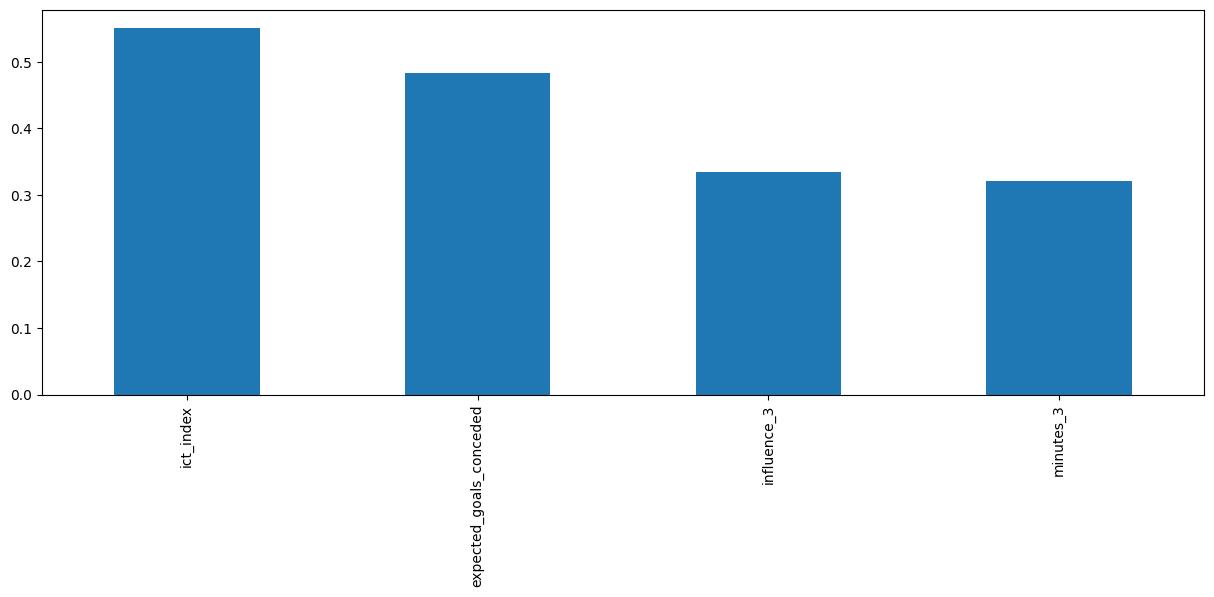

In [48]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))

##### Select to 20% perct

In [49]:
from sklearn.feature_selection import SelectPercentile

## Selecting the top 20 percentile
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=50)
selected_top_columns.fit(k_sel_X_train, gk_splits['target_train'])

selected_top_columns.get_support()

array([ True,  True, False, False])

In [50]:
gk_20_columns = k_sel_X_train.columns[selected_top_columns.get_support()]

gk_20_train = k_sel_X_train[gk_20_columns]
gk_20_test = k_sel_X_test[gk_20_columns]


In [51]:
gk_20_train.shape, gk_20_test.shape

((2410, 2), (603, 2))

##### Model (MI)

###### Linear Model

In [52]:

MI_gk_lin_reg = Linear_regression(gk_20_train, gk_20_test,
                               gk_splits['target_train'], gk_splits['target_test'])

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(MI_gk_lin_reg =  [MI_gk_lin_reg['train_RMSE'], MI_gk_lin_reg['test_RMSE'], MI_gk_lin_reg['cv_rmse'], MI_gk_lin_reg['R2_train'], MI_gk_lin_reg['R2_test']])

gk_evaluation_stats

Training set RMSE: 1.230951040553926
Test set RMSE: 1.2905256333309723
Training set R2: 0.5622393586797589
Test set R2: 0.5657286179995822
count    10.000000
mean      1.232946
std       0.127732
min       1.020281
25%       1.150593
50%       1.248692
75%       1.277790
max       1.482645
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg,KBest_gk_dt_reg,KBest_gk_rf_reg,KBest_gk_xgb_reg,MI_gk_lin_reg
train_RMSE,1.163184,0.020325,0.751638,0.914098,1.163184e+00,0.020325,0.750556,0.914098,1.175211,0.020364,0.755365,0.934782,1.230951
test_RMSE,1.226177,1.590812,1.134714,1.115905,4.310737e+10,1.596015,1.129026,1.115905,1.234940,1.725335,1.174796,1.159839,1.290526
cv_rmse,1.203451,1.570235,1.149097,1.127393,1.203398e+00,1.586941,1.145192,1.127393,1.178229,1.503237,1.122553,1.120977,1.232946
R2_train,0.609112,0.999881,0.836780,0.758598,6.091122e-01,0.999881,0.837250,0.758598,0.600987,0.999880,0.835158,0.747550,0.562239
R2_test,0.607956,0.340119,0.664262,0.675300,-4.845414e+20,0.335795,0.667620,0.675300,0.602333,0.223798,0.640124,0.649229,0.565729


###### DecisionTree Model

In [53]:
MI_gk_dt_reg = DecisionTreeRegression(gk_20_train, gk_20_test,
                               gk_splits['target_train'], gk_splits['target_test'])

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(MI_gk_dt_reg = [MI_gk_dt_reg['train_RMSE'], MI_gk_dt_reg['test_RMSE'], MI_gk_dt_reg['cv_rmse'], MI_gk_dt_reg['R2_train'], MI_gk_dt_reg['R2_test']])

gk_evaluation_stats



Training set RMSE: 0.14547028546368668
Test set RMSE: 1.5940644446880419
Training set R2: 0.9938863054832541
Test set R2: 0.3374179131582463
count    10.000000
mean      1.491095
std       0.240247
min       1.078361
25%       1.303592
50%       1.538654
75%       1.663127
max       1.820811
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg,KBest_gk_dt_reg,KBest_gk_rf_reg,KBest_gk_xgb_reg,MI_gk_lin_reg,MI_gk_dt_reg
train_RMSE,1.163184,0.020325,0.751638,0.914098,1.163184e+00,0.020325,0.750556,0.914098,1.175211,0.020364,0.755365,0.934782,1.230951,0.145470
test_RMSE,1.226177,1.590812,1.134714,1.115905,4.310737e+10,1.596015,1.129026,1.115905,1.234940,1.725335,1.174796,1.159839,1.290526,1.594064
cv_rmse,1.203451,1.570235,1.149097,1.127393,1.203398e+00,1.586941,1.145192,1.127393,1.178229,1.503237,1.122553,1.120977,1.232946,1.491095
R2_train,0.609112,0.999881,0.836780,0.758598,6.091122e-01,0.999881,0.837250,0.758598,0.600987,0.999880,0.835158,0.747550,0.562239,0.993886
R2_test,0.607956,0.340119,0.664262,0.675300,-4.845414e+20,0.335795,0.667620,0.675300,0.602333,0.223798,0.640124,0.649229,0.565729,0.337418


###### RandomForest Model

In [54]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
MI_gk_rf_reg = RandomForestRegression(gk_20_train, gk_20_test,
                               gk_splits['target_train'], gk_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(MI_gk_rf_reg = [MI_gk_rf_reg['train_RMSE'], MI_gk_rf_reg['test_RMSE'], MI_gk_rf_reg['cv_rmse'], MI_gk_rf_reg['R2_train'], MI_gk_rf_reg['R2_test']])

gk_evaluation_stats

count    10.000000
mean      1.120912
std       0.140224
min       0.923123
25%       1.036120
50%       1.121398
75%       1.209726
max       1.368728
dtype: float64


,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg,KBest_gk_dt_reg,KBest_gk_rf_reg,KBest_gk_xgb_reg,MI_gk_lin_reg,MI_gk_dt_reg,MI_gk_rf_reg
train_RMSE,1.163184,0.020325,0.751638,0.914098,1.163184e+00,0.020325,0.750556,0.914098,1.175211,0.020364,0.755365,0.934782,1.230951,0.145470,0.805448
test_RMSE,1.226177,1.590812,1.134714,1.115905,4.310737e+10,1.596015,1.129026,1.115905,1.234940,1.725335,1.174796,1.159839,1.290526,1.594064,1.195555
cv_rmse,1.203451,1.570235,1.149097,1.127393,1.203398e+00,1.586941,1.145192,1.127393,1.178229,1.503237,1.122553,1.120977,1.232946,1.491095,1.120912
R2_train,0.609112,0.999881,0.836780,0.758598,6.091122e-01,0.999881,0.837250,0.758598,0.600987,0.999880,0.835158,0.747550,0.562239,0.993886,0.812574
R2_test,0.607956,0.340119,0.664262,0.675300,-4.845414e+20,0.335795,0.667620,0.675300,0.602333,0.223798,0.640124,0.649229,0.565729,0.337418,0.627294


###### XgBoost Model

In [55]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
MI_gk_xgb_reg = XGBoostRegression(k_sel_X_train, k_sel_X_test, gk_splits['target_train'], gk_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = gk_evaluation_stats.assign(MI_gk_xgb_reg = [MI_gk_xgb_reg['train_RMSE'], MI_gk_xgb_reg['test_RMSE'], MI_gk_xgb_reg['cv_rmse'], MI_gk_xgb_reg['R2_train'], MI_gk_xgb_reg['R2_test']])
gk_evaluation_stats

,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg,KBest_gk_dt_reg,KBest_gk_rf_reg,KBest_gk_xgb_reg,MI_gk_lin_reg,MI_gk_dt_reg,MI_gk_rf_reg,MI_gk_xgb_reg
train_RMSE,1.163184,0.020325,0.751638,0.914098,1.163184e+00,0.020325,0.750556,0.914098,1.175211,0.020364,0.755365,0.934782,1.230951,0.145470,0.805448,0.934782
test_RMSE,1.226177,1.590812,1.134714,1.115905,4.310737e+10,1.596015,1.129026,1.115905,1.234940,1.725335,1.174796,1.159839,1.290526,1.594064,1.195555,1.159839
cv_rmse,1.203451,1.570235,1.149097,1.127393,1.203398e+00,1.586941,1.145192,1.127393,1.178229,1.503237,1.122553,1.120977,1.232946,1.491095,1.120912,1.120977
R2_train,0.609112,0.999881,0.836780,0.758598,6.091122e-01,0.999881,0.837250,0.758598,0.600987,0.999880,0.835158,0.747550,0.562239,0.993886,0.812574,0.747550
R2_test,0.607956,0.340119,0.664262,0.675300,-4.845414e+20,0.335795,0.667620,0.675300,0.602333,0.223798,0.640124,0.649229,0.565729,0.337418,0.627294,0.649229


## Defenders


### VarianceThreshold

In [56]:
VT_scaler = StandardScaler()
df_def_train_scaled = pd.DataFrame(VT_scaler.fit_transform(def_splits['feature_train']), columns=def_splits['feature_train'].columns)
df_def_test_scaled = pd.DataFrame(VT_scaler.transform(def_splits['features_test']), columns=def_splits['features_test'].columns)

selector = VarianceThreshold(threshold = 0.1)
selector.fit_transform(df_def_train_scaled)

def_threshold_columns = df_def_train_scaled.columns[selector.get_support()]

def_threshold_train = df_def_train_scaled[def_threshold_columns]
def_threshold_test = df_def_test_scaled[def_threshold_columns]

def_threshold_train.shape, def_threshold_test.shape

((6789, 21), (1698, 21))

#### Model(VT)

##### Linear Model

In [57]:

VarT_def_lin_reg = Linear_regression(def_threshold_train, def_threshold_test,
                               def_splits['target_train'], def_splits['target_test'])

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(VarT_def_lin_reg =  [VarT_def_lin_reg['train_RMSE'], VarT_def_lin_reg['test_RMSE'], VarT_def_lin_reg['cv_rmse'], VarT_def_lin_reg['R2_train'], VarT_def_lin_reg['R2_test']])

def_evaluation_stats

Training set RMSE: 1.5270280804028498
Test set RMSE: 1.5505165892619626
Training set R2: 0.5319757200356232
Test set R2: 0.4946086151682634
count    10.000000
mean      1.536271
std       0.138668
min       1.298746
25%       1.472816
50%       1.544351
75%       1.587872
max       1.798348
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg
train_RMSE,1.527028,0.036669,1.153646,1.346300,1.527028
test_RMSE,1.550517,2.056333,1.504532,1.458321,1.550517
cv_rmse,1.536271,2.113417,1.497470,1.491973,1.536271
R2_train,0.531976,0.999730,0.732872,0.636204,0.531976
R2_test,0.494609,0.111082,0.524141,0.552924,0.494609


##### DecisionTree Model

In [58]:
VarT_def_dt_reg = DecisionTreeRegression(def_threshold_train, def_threshold_test,
                               def_splits['target_train'], def_splits['target_test'])

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(VarT_def_dt_reg = [VarT_def_dt_reg['train_RMSE'], VarT_def_dt_reg['test_RMSE'], VarT_def_dt_reg['cv_rmse'], VarT_def_dt_reg['R2_train'], VarT_def_dt_reg['R2_test']])

def_evaluation_stats



Training set RMSE: 0.036669292085192096
Test set RMSE: 2.046860064276527
Training set R2: 0.9997301146014806
Test set R2: 0.11925273058744867
count    10.000000
mean      2.116403
std       0.177979
min       1.864819
25%       1.973183
50%       2.096425
75%       2.268370
max       2.399375
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg
train_RMSE,1.527028,0.036669,1.153646,1.346300,1.527028,0.036669
test_RMSE,1.550517,2.056333,1.504532,1.458321,1.550517,2.046860
cv_rmse,1.536271,2.113417,1.497470,1.491973,1.536271,2.116403
R2_train,0.531976,0.999730,0.732872,0.636204,0.531976,0.999730
R2_test,0.494609,0.111082,0.524141,0.552924,0.494609,0.119253


##### RandomForest Model

In [59]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
VarT_def_rf_reg = RandomForestRegression(def_threshold_train, def_threshold_test,
                               def_splits['target_train'], def_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(VarT_def_rf_reg = [VarT_def_rf_reg['train_RMSE'], VarT_def_rf_reg['test_RMSE'], VarT_def_rf_reg['cv_rmse'], VarT_def_rf_reg['R2_train'], VarT_def_rf_reg['R2_test']])

def_evaluation_stats

count    10.000000
mean      1.498864
std       0.158402
min       1.285549
25%       1.374860
50%       1.519270
75%       1.548563
max       1.780251
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg
train_RMSE,1.527028,0.036669,1.153646,1.346300,1.527028,0.036669,1.154000
test_RMSE,1.550517,2.056333,1.504532,1.458321,1.550517,2.046860,1.508357
cv_rmse,1.536271,2.113417,1.497470,1.491973,1.536271,2.116403,1.498864
R2_train,0.531976,0.999730,0.732872,0.636204,0.531976,0.999730,0.732708
R2_test,0.494609,0.111082,0.524141,0.552924,0.494609,0.119253,0.521719


##### XgBoost Model

In [60]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
VarT_def_xgb_reg = XGBoostRegression(def_threshold_train, def_threshold_test, def_splits['target_train'], def_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(VarT_def_xgb_reg = [VarT_def_xgb_reg['train_RMSE'], VarT_def_xgb_reg['test_RMSE'], VarT_def_xgb_reg['cv_rmse'], VarT_def_xgb_reg['R2_train'], VarT_def_xgb_reg['R2_test']])
def_evaluation_stats

,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg
train_RMSE,1.527028,0.036669,1.153646,1.346300,1.527028,0.036669,1.154000,1.346300
test_RMSE,1.550517,2.056333,1.504532,1.458321,1.550517,2.046860,1.508357,1.458321
cv_rmse,1.536271,2.113417,1.497470,1.491973,1.536271,2.116403,1.498864,1.491973
R2_train,0.531976,0.999730,0.732872,0.636204,0.531976,0.999730,0.732708,0.636204
R2_test,0.494609,0.111082,0.524141,0.552924,0.494609,0.119253,0.521719,0.552924


### Feature selection techniques

#### K-best features

In [61]:

from sklearn.feature_selection import SelectKBest, mutual_info_regression

k_rf_model = RandomForestRegressor(n_estimators=20,  max_depth=8, criterion='friedman_mse', max_features='sqrt', random_state=18)

score_list  = []

for k in range(1, 21):
  selector = SelectKBest(mutual_info_regression, k=k)
  k_sel_X_train =  selector.fit_transform(def_threshold_train, def_splits['target_train'])

  k_rf_model.fit(k_sel_X_train, def_splits['target_train'])

  k_sel_cols = def_threshold_train.columns[selector.get_support()]
  k_sel_X_test = def_threshold_test[k_sel_cols]
  score = round(k_rf_model.score(k_sel_X_test.values, def_splits['target_test'] ), 3)

  score_list.append(score)
print(score_list, score_list.index(max(score_list)))
num_of_feat = score_list.index(max(score_list)) # find the highest score. We will use  that as the value of k

[0.432, 0.514, 0.533, 0.533, 0.547, 0.523, 0.524, 0.53, 0.528, 0.527, 0.504, 0.486, 0.507, 0.503, 0.518, 0.497, 0.51, 0.487, 0.502, 0.486] 4


In [62]:
selector = SelectKBest(mutual_info_regression, k=num_of_feat+1)
selector.fit_transform(def_threshold_train, def_splits['target_train'])

sel_feats = selector.get_feature_names_out()
k_sel_X_train = def_threshold_train[sel_feats]
k_sel_X_test = def_threshold_test[sel_feats]

##### Model (KBest)

###### Linear Model

In [63]:

KBest_def_lin_reg = Linear_regression(k_sel_X_train, k_sel_X_test,
                               def_splits['target_train'], def_splits['target_test'])

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(KBest_def_lin_reg =  [KBest_def_lin_reg['train_RMSE'], KBest_def_lin_reg['test_RMSE'], KBest_def_lin_reg['cv_rmse'], KBest_def_lin_reg['R2_train'], KBest_def_lin_reg['R2_test']])

def_evaluation_stats

Training set RMSE: 1.5334208675635381
Test set RMSE: 1.5563072147995818
Training set R2: 0.5280488211211938
Test set R2: 0.49082665365163536
count    10.000000
mean      1.534299
std       0.136208
min       1.299906
25%       1.461186
50%       1.548238
75%       1.583342
max       1.786919
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg
train_RMSE,1.527028,0.036669,1.153646,1.346300,1.527028,0.036669,1.154000,1.346300,1.533421
test_RMSE,1.550517,2.056333,1.504532,1.458321,1.550517,2.046860,1.508357,1.458321,1.556307
cv_rmse,1.536271,2.113417,1.497470,1.491973,1.536271,2.116403,1.498864,1.491973,1.534299
R2_train,0.531976,0.999730,0.732872,0.636204,0.531976,0.999730,0.732708,0.636204,0.528049
R2_test,0.494609,0.111082,0.524141,0.552924,0.494609,0.119253,0.521719,0.552924,0.490827


###### DecisionTree Model

In [64]:
KBest_def_dt_reg = DecisionTreeRegression(k_sel_X_train, k_sel_X_test,
                               def_splits['target_train'], def_splits['target_test'])

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(KBest_def_dt_reg = [KBest_def_dt_reg['train_RMSE'], KBest_def_dt_reg['test_RMSE'], KBest_def_dt_reg['cv_rmse'], KBest_def_dt_reg['R2_train'], KBest_def_dt_reg['R2_test']])

def_evaluation_stats



Training set RMSE: 0.04930505477059901
Test set RMSE: 2.0447089323253453
Training set R2: 0.9995120703290946
Test set R2: 0.1211029870515915
count    10.000000
mean      2.015223
std       0.191506
min       1.606207
25%       1.930892
50%       2.042140
75%       2.115634
max       2.297161
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg
train_RMSE,1.527028,0.036669,1.153646,1.346300,1.527028,0.036669,1.154000,1.346300,1.533421,0.049305
test_RMSE,1.550517,2.056333,1.504532,1.458321,1.550517,2.046860,1.508357,1.458321,1.556307,2.044709
cv_rmse,1.536271,2.113417,1.497470,1.491973,1.536271,2.116403,1.498864,1.491973,1.534299,2.015223
R2_train,0.531976,0.999730,0.732872,0.636204,0.531976,0.999730,0.732708,0.636204,0.528049,0.999512
R2_test,0.494609,0.111082,0.524141,0.552924,0.494609,0.119253,0.521719,0.552924,0.490827,0.121103


###### RandomForest Model

In [65]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
KBest_def_rf_reg = RandomForestRegression(k_sel_X_train, k_sel_X_test,
                               def_splits['target_train'], def_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(KBest_def_rf_reg = [KBest_def_rf_reg['train_RMSE'], KBest_def_rf_reg['test_RMSE'], KBest_def_rf_reg['cv_rmse'], KBest_def_rf_reg['R2_train'], KBest_def_rf_reg['R2_test']])

def_evaluation_stats

count    10.000000
mean      1.500180
std       0.149952
min       1.285503
25%       1.389531
50%       1.525857
75%       1.554395
max       1.730237
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg,KBest_def_rf_reg
train_RMSE,1.527028,0.036669,1.153646,1.346300,1.527028,0.036669,1.154000,1.346300,1.533421,0.049305,1.210142
test_RMSE,1.550517,2.056333,1.504532,1.458321,1.550517,2.046860,1.508357,1.458321,1.556307,2.044709,1.485602
cv_rmse,1.536271,2.113417,1.497470,1.491973,1.536271,2.116403,1.498864,1.491973,1.534299,2.015223,1.500180
R2_train,0.531976,0.999730,0.732872,0.636204,0.531976,0.999730,0.732708,0.636204,0.528049,0.999512,0.706068
R2_test,0.494609,0.111082,0.524141,0.552924,0.494609,0.119253,0.521719,0.552924,0.490827,0.121103,0.536041


###### XgBoost Model

In [66]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
KBest_def_xgb_reg = XGBoostRegression(k_sel_X_train, k_sel_X_test, def_splits['target_train'], def_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(KBest_def_xgb_reg = [KBest_def_xgb_reg['train_RMSE'], KBest_def_xgb_reg['test_RMSE'], KBest_def_xgb_reg['cv_rmse'], KBest_def_xgb_reg['R2_train'], KBest_def_xgb_reg['R2_test']])
def_evaluation_stats

,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg,KBest_def_rf_reg,KBest_def_xgb_reg
train_RMSE,1.527028,0.036669,1.153646,1.346300,1.527028,0.036669,1.154000,1.346300,1.533421,0.049305,1.210142,1.362236
test_RMSE,1.550517,2.056333,1.504532,1.458321,1.550517,2.046860,1.508357,1.458321,1.556307,2.044709,1.485602,1.462316
cv_rmse,1.536271,2.113417,1.497470,1.491973,1.536271,2.116403,1.498864,1.491973,1.534299,2.015223,1.500180,1.491606
R2_train,0.531976,0.999730,0.732872,0.636204,0.531976,0.999730,0.732708,0.636204,0.528049,0.999512,0.706068,0.627541
R2_test,0.494609,0.111082,0.524141,0.552924,0.494609,0.119253,0.521719,0.552924,0.490827,0.121103,0.536041,0.550471


#### Mutual Information

In [67]:
from sklearn.feature_selection import mutual_info_regression
# def_sel_X_train
mutual_info = mutual_info_regression(k_sel_X_train, def_splits['target_train'])
mutual_info

array([0.53895678, 0.26876172, 0.31783727, 0.50650577, 0.23007111])

In [68]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = k_sel_X_train.columns
mutual_info.sort_values(ascending=False)

,0
ict_index,0.538957
expected_goals_conceded,0.506506
expected_goal_involvements,0.317837
expected_assists,0.268762
minutes_3,0.230071


<Axes: >

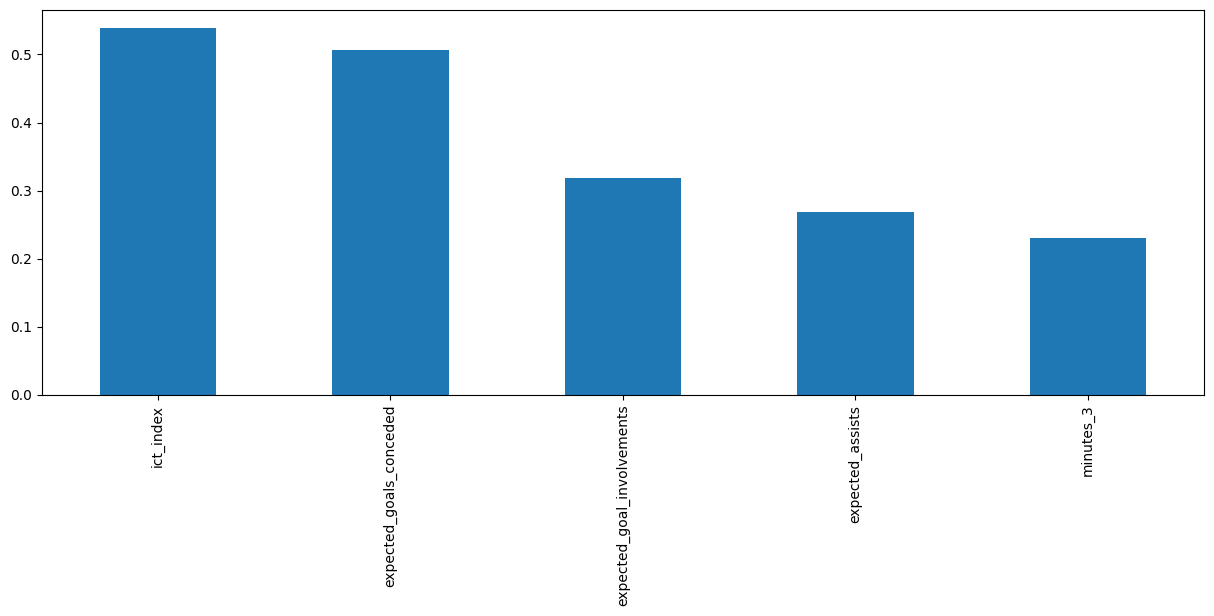

In [69]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))

##### Select to 20% perct

In [70]:
from sklearn.feature_selection import SelectPercentile

## Selecting the top 20 percentile
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=50)
selected_top_columns.fit(k_sel_X_train, def_splits['target_train'])

selected_top_columns.get_support()

array([ True, False, False,  True, False])

In [71]:
def_20_columns = k_sel_X_train.columns[selected_top_columns.get_support()]

def_20_train = k_sel_X_train[def_20_columns]
def_20_test = k_sel_X_test[def_20_columns]


##### Model (MI)

###### Linear Model

In [72]:

MI_def_lin_reg = Linear_regression(def_20_train, def_20_test,
                               def_splits['target_train'], def_splits['target_test'])

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(MI_def_lin_reg =  [MI_def_lin_reg['train_RMSE'], MI_def_lin_reg['test_RMSE'], MI_def_lin_reg['cv_rmse'], MI_def_lin_reg['R2_train'], MI_def_lin_reg['R2_test']])

def_evaluation_stats

Training set RMSE: 1.5558462172706184
Test set RMSE: 1.5845575395816487
Training set R2: 0.5141438843435433
Test set R2: 0.4721736969889555
count    10.000000
mean      1.552624
std       0.131912
min       1.302669
25%       1.478647
50%       1.572864
75%       1.627865
max       1.761496
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg,KBest_def_rf_reg,KBest_def_xgb_reg,MI_def_lin_reg
train_RMSE,1.527028,0.036669,1.153646,1.346300,1.527028,0.036669,1.154000,1.346300,1.533421,0.049305,1.210142,1.362236,1.555846
test_RMSE,1.550517,2.056333,1.504532,1.458321,1.550517,2.046860,1.508357,1.458321,1.556307,2.044709,1.485602,1.462316,1.584558
cv_rmse,1.536271,2.113417,1.497470,1.491973,1.536271,2.116403,1.498864,1.491973,1.534299,2.015223,1.500180,1.491606,1.552624
R2_train,0.531976,0.999730,0.732872,0.636204,0.531976,0.999730,0.732708,0.636204,0.528049,0.999512,0.706068,0.627541,0.514144
R2_test,0.494609,0.111082,0.524141,0.552924,0.494609,0.119253,0.521719,0.552924,0.490827,0.121103,0.536041,0.550471,0.472174


###### DecisionTree Model

In [73]:
MI_def_dt_reg = DecisionTreeRegression(def_20_train, def_20_test,
                               def_splits['target_train'], def_splits['target_test'])

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(MI_def_dt_reg = [MI_def_dt_reg['train_RMSE'], MI_def_dt_reg['test_RMSE'], MI_def_dt_reg['cv_rmse'], MI_def_dt_reg['R2_train'], MI_def_dt_reg['R2_test']])

def_evaluation_stats



Training set RMSE: 0.369670587395037
Test set RMSE: 2.069875604096306
Training set R2: 0.9725713689764599
Test set R2: 0.09933457374418897
count    10.000000
mean      1.960498
std       0.192225
min       1.635252
25%       1.836397
50%       1.934142
75%       2.070510
max       2.280753
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg,KBest_def_rf_reg,KBest_def_xgb_reg,MI_def_lin_reg,MI_def_dt_reg
train_RMSE,1.527028,0.036669,1.153646,1.346300,1.527028,0.036669,1.154000,1.346300,1.533421,0.049305,1.210142,1.362236,1.555846,0.369671
test_RMSE,1.550517,2.056333,1.504532,1.458321,1.550517,2.046860,1.508357,1.458321,1.556307,2.044709,1.485602,1.462316,1.584558,2.069876
cv_rmse,1.536271,2.113417,1.497470,1.491973,1.536271,2.116403,1.498864,1.491973,1.534299,2.015223,1.500180,1.491606,1.552624,1.960498
R2_train,0.531976,0.999730,0.732872,0.636204,0.531976,0.999730,0.732708,0.636204,0.528049,0.999512,0.706068,0.627541,0.514144,0.972571
R2_test,0.494609,0.111082,0.524141,0.552924,0.494609,0.119253,0.521719,0.552924,0.490827,0.121103,0.536041,0.550471,0.472174,0.099335


###### RandomForest Model

In [74]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
MI_def_rf_reg = RandomForestRegression(def_20_train, def_20_test,
                               def_splits['target_train'], def_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(MI_def_rf_reg = [MI_def_rf_reg['train_RMSE'], MI_def_rf_reg['test_RMSE'], MI_def_rf_reg['cv_rmse'], MI_def_rf_reg['R2_train'], MI_def_rf_reg['R2_test']])

def_evaluation_stats

count    10.000000
mean      1.506603
std       0.135631
min       1.300123
25%       1.407926
50%       1.506312
75%       1.576083
max       1.730577
dtype: float64


,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg,KBest_def_rf_reg,KBest_def_xgb_reg,MI_def_lin_reg,MI_def_dt_reg,MI_def_rf_reg
train_RMSE,1.527028,0.036669,1.153646,1.346300,1.527028,0.036669,1.154000,1.346300,1.533421,0.049305,1.210142,1.362236,1.555846,0.369671,1.266408
test_RMSE,1.550517,2.056333,1.504532,1.458321,1.550517,2.046860,1.508357,1.458321,1.556307,2.044709,1.485602,1.462316,1.584558,2.069876,1.538249
cv_rmse,1.536271,2.113417,1.497470,1.491973,1.536271,2.116403,1.498864,1.491973,1.534299,2.015223,1.500180,1.491606,1.552624,1.960498,1.506603
R2_train,0.531976,0.999730,0.732872,0.636204,0.531976,0.999730,0.732708,0.636204,0.528049,0.999512,0.706068,0.627541,0.514144,0.972571,0.678100
R2_test,0.494609,0.111082,0.524141,0.552924,0.494609,0.119253,0.521719,0.552924,0.490827,0.121103,0.536041,0.550471,0.472174,0.099335,0.502574


###### XgBoost Model

In [75]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
MI_def_xgb_reg = XGBoostRegression(k_sel_X_train, k_sel_X_test, def_splits['target_train'], def_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
def_evaluation_stats = def_evaluation_stats.assign(MI_def_xgb_reg = [MI_def_xgb_reg['train_RMSE'], MI_def_xgb_reg['test_RMSE'], MI_def_xgb_reg['cv_rmse'], MI_def_xgb_reg['R2_train'], MI_def_xgb_reg['R2_test']])
def_evaluation_stats

,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg,KBest_def_rf_reg,KBest_def_xgb_reg,MI_def_lin_reg,MI_def_dt_reg,MI_def_rf_reg,MI_def_xgb_reg
train_RMSE,1.527028,0.036669,1.153646,1.346300,1.527028,0.036669,1.154000,1.346300,1.533421,0.049305,1.210142,1.362236,1.555846,0.369671,1.266408,1.362236
test_RMSE,1.550517,2.056333,1.504532,1.458321,1.550517,2.046860,1.508357,1.458321,1.556307,2.044709,1.485602,1.462316,1.584558,2.069876,1.538249,1.462316
cv_rmse,1.536271,2.113417,1.497470,1.491973,1.536271,2.116403,1.498864,1.491973,1.534299,2.015223,1.500180,1.491606,1.552624,1.960498,1.506603,1.491606
R2_train,0.531976,0.999730,0.732872,0.636204,0.531976,0.999730,0.732708,0.636204,0.528049,0.999512,0.706068,0.627541,0.514144,0.972571,0.678100,0.627541
R2_test,0.494609,0.111082,0.524141,0.552924,0.494609,0.119253,0.521719,0.552924,0.490827,0.121103,0.536041,0.550471,0.472174,0.099335,0.502574,0.550471


## Midfielders


### VarianceThreshold

In [76]:
VT_scaler = StandardScaler()
df_mid_train_scaled = pd.DataFrame(VT_scaler.fit_transform(mid_splits['feature_train']), columns=mid_splits['feature_train'].columns)
df_mid_test_scaled = pd.DataFrame(VT_scaler.transform(mid_splits['features_test']), columns=mid_splits['features_test'].columns)

selector = VarianceThreshold(threshold = 0.1)
selector.fit_transform(df_mid_train_scaled)

mid_threshold_columns = df_mid_train_scaled.columns[selector.get_support()]

mid_threshold_train = df_mid_train_scaled[mid_threshold_columns]
mid_threshold_test = df_mid_test_scaled[mid_threshold_columns]

mid_threshold_train.shape, mid_threshold_test.shape

((9070, 22), (2268, 22))

#### Model(VT)

##### Linear Model

In [77]:

VarT_mid_lin_reg = Linear_regression(mid_threshold_train, mid_threshold_test,
                               mid_splits['target_train'], mid_splits['target_test'])

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(VarT_mid_lin_reg =  [VarT_mid_lin_reg['train_RMSE'], VarT_mid_lin_reg['test_RMSE'], VarT_mid_lin_reg['cv_rmse'], VarT_mid_lin_reg['R2_train'], VarT_mid_lin_reg['R2_test']])

mid_evaluation_stats

Training set RMSE: 1.214108858869288
Test set RMSE: 1.1827392882221606
Training set R2: 0.749767079751025
Test set R2: 0.7401505379499281
count    10.000000
mean      1.220826
std       0.082095
min       1.095855
25%       1.168832
50%       1.204511
75%       1.275988
max       1.377943
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg
train_RMSE,1.214109,0.042880,0.846176,1.037749,1.214109
test_RMSE,1.182739,1.672228,1.109898,1.103781,1.182739
cv_rmse,1.220826,1.617324,1.181929,1.176367,1.220826
R2_train,0.749767,0.999688,0.878451,0.817184,0.749767
R2_test,0.740151,0.480561,0.771171,0.773687,0.740151


##### DecisionTree Model

In [78]:
VarT_mid_dt_reg = DecisionTreeRegression(mid_threshold_train, mid_threshold_test,
                               mid_splits['target_train'], mid_splits['target_test'])

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(VarT_mid_dt_reg = [VarT_mid_dt_reg['train_RMSE'], VarT_mid_dt_reg['test_RMSE'], VarT_mid_dt_reg['cv_rmse'], VarT_mid_dt_reg['R2_train'], VarT_mid_dt_reg['R2_test']])

mid_evaluation_stats



Training set RMSE: 0.04288004543682626
Test set RMSE: 1.668664781026135
Training set R2: 0.9996878670176392
Test set R2: 0.4827720625254427
count    10.000000
mean      1.633782
std       0.137666
min       1.419469
25%       1.582776
50%       1.594834
75%       1.693400
max       1.888022
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg
train_RMSE,1.214109,0.042880,0.846176,1.037749,1.214109,0.042880
test_RMSE,1.182739,1.672228,1.109898,1.103781,1.182739,1.668665
cv_rmse,1.220826,1.617324,1.181929,1.176367,1.220826,1.633782
R2_train,0.749767,0.999688,0.878451,0.817184,0.749767,0.999688
R2_test,0.740151,0.480561,0.771171,0.773687,0.740151,0.482772


##### RandomForest Model

In [79]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
VarT_mid_rf_reg = RandomForestRegression(mid_threshold_train, mid_threshold_test,
                               mid_splits['target_train'], mid_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(VarT_mid_rf_reg = [VarT_mid_rf_reg['train_RMSE'], VarT_mid_rf_reg['test_RMSE'], VarT_mid_rf_reg['cv_rmse'], VarT_mid_rf_reg['R2_train'], VarT_mid_rf_reg['R2_test']])

mid_evaluation_stats

count    10.000000
mean      1.181397
std       0.080301
min       1.026529
25%       1.161497
50%       1.177553
75%       1.215566
max       1.310249
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg
train_RMSE,1.214109,0.042880,0.846176,1.037749,1.214109,0.042880,0.844437
test_RMSE,1.182739,1.672228,1.109898,1.103781,1.182739,1.668665,1.104714
cv_rmse,1.220826,1.617324,1.181929,1.176367,1.220826,1.633782,1.181397
R2_train,0.749767,0.999688,0.878451,0.817184,0.749767,0.999688,0.878950
R2_test,0.740151,0.480561,0.771171,0.773687,0.740151,0.482772,0.773304


##### XgBoost Model

In [80]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
VarT_mid_xgb_reg = XGBoostRegression(mid_threshold_train, mid_threshold_test, mid_splits['target_train'], mid_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(VarT_mid_xgb_reg = [VarT_mid_xgb_reg['train_RMSE'], VarT_mid_xgb_reg['test_RMSE'], VarT_mid_xgb_reg['cv_rmse'], VarT_mid_xgb_reg['R2_train'], VarT_mid_xgb_reg['R2_test']])
mid_evaluation_stats

,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg
train_RMSE,1.214109,0.042880,0.846176,1.037749,1.214109,0.042880,0.844437,1.037749
test_RMSE,1.182739,1.672228,1.109898,1.103781,1.182739,1.668665,1.104714,1.103781
cv_rmse,1.220826,1.617324,1.181929,1.176367,1.220826,1.633782,1.181397,1.176367
R2_train,0.749767,0.999688,0.878451,0.817184,0.749767,0.999688,0.878950,0.817184
R2_test,0.740151,0.480561,0.771171,0.773687,0.740151,0.482772,0.773304,0.773687


### Feature selection techniques

#### K-best features

In [81]:

from sklearn.feature_selection import SelectKBest, mutual_info_regression

k_rf_model = RandomForestRegressor(n_estimators=20,  max_depth=8, criterion='friedman_mse', max_features='sqrt', random_state=18)

score_list  = []

for k in range(1, 21):
  selector = SelectKBest(mutual_info_regression, k=k)
  k_sel_X_train =  selector.fit_transform(mid_threshold_train, mid_splits['target_train'])

  k_rf_model.fit(k_sel_X_train, mid_splits['target_train'])

  k_sel_cols = mid_threshold_train.columns[selector.get_support()]
  k_sel_X_test = mid_threshold_test[k_sel_cols]
  score = round(k_rf_model.score(k_sel_X_test.values, mid_splits['target_test'] ), 3)

  score_list.append(score)
print(score_list, score_list.index(max(score_list)))
num_of_feat = score_list.index(max(score_list)) # find the highest score. We will use  that as the value of k

[0.718, 0.727, 0.741, 0.776, 0.773, 0.762, 0.758, 0.754, 0.762, 0.755, 0.756, 0.756, 0.758, 0.746, 0.741, 0.754, 0.766, 0.749, 0.735, 0.751] 3


In [82]:
selector = SelectKBest(mutual_info_regression, k=num_of_feat)
selector.fit_transform(mid_threshold_train, mid_splits['target_train'])

sel_feats = selector.get_feature_names_out()
k_sel_X_train = mid_threshold_train[sel_feats]
k_sel_X_test = mid_threshold_test[sel_feats]

##### Model (KBest)

###### Linear Model

In [83]:

KBest_mid_lin_reg = Linear_regression(k_sel_X_train, k_sel_X_test,
                               mid_splits['target_train'], mid_splits['target_test'])

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(KBest_mid_lin_reg =  [KBest_mid_lin_reg['train_RMSE'], KBest_mid_lin_reg['test_RMSE'], KBest_mid_lin_reg['cv_rmse'], KBest_mid_lin_reg['R2_train'], KBest_mid_lin_reg['R2_test']])

mid_evaluation_stats

Training set RMSE: 1.2575779488761993
Test set RMSE: 1.2143661124988046
Training set R2: 0.7315279893256357
Test set R2: 0.7260678196799714
count    10.000000
mean      1.257376
std       0.091229
min       1.158048
25%       1.181135
50%       1.241885
75%       1.327509
max       1.415362
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg
train_RMSE,1.214109,0.042880,0.846176,1.037749,1.214109,0.042880,0.844437,1.037749,1.257578
test_RMSE,1.182739,1.672228,1.109898,1.103781,1.182739,1.668665,1.104714,1.103781,1.214366
cv_rmse,1.220826,1.617324,1.181929,1.176367,1.220826,1.633782,1.181397,1.176367,1.257376
R2_train,0.749767,0.999688,0.878451,0.817184,0.749767,0.999688,0.878950,0.817184,0.731528
R2_test,0.740151,0.480561,0.771171,0.773687,0.740151,0.482772,0.773304,0.773687,0.726068


###### DecisionTree Model

In [84]:
KBest_mid_dt_reg = DecisionTreeRegression(k_sel_X_train, k_sel_X_test,
                               mid_splits['target_train'], mid_splits['target_test'])

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(KBest_mid_dt_reg = [KBest_mid_dt_reg['train_RMSE'], KBest_mid_dt_reg['test_RMSE'], KBest_mid_dt_reg['cv_rmse'], KBest_mid_dt_reg['R2_train'], KBest_mid_dt_reg['R2_test']])

mid_evaluation_stats



Training set RMSE: 0.09304845085076233
Test set RMSE: 1.5996537422180657
Training set R2: 0.9985302364176558
Test set R2: 0.5246694280110124
count    10.000000
mean      1.712605
std       0.113257
min       1.535326
25%       1.669595
50%       1.692123
75%       1.731816
max       1.970697
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg,KBest_mid_dt_reg
train_RMSE,1.214109,0.042880,0.846176,1.037749,1.214109,0.042880,0.844437,1.037749,1.257578,0.093048
test_RMSE,1.182739,1.672228,1.109898,1.103781,1.182739,1.668665,1.104714,1.103781,1.214366,1.599654
cv_rmse,1.220826,1.617324,1.181929,1.176367,1.220826,1.633782,1.181397,1.176367,1.257376,1.712605
R2_train,0.749767,0.999688,0.878451,0.817184,0.749767,0.999688,0.878950,0.817184,0.731528,0.998530
R2_test,0.740151,0.480561,0.771171,0.773687,0.740151,0.482772,0.773304,0.773687,0.726068,0.524669


###### RandomForest Model

In [85]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
KBest_mid_rf_reg = RandomForestRegression(k_sel_X_train, k_sel_X_test,
                               mid_splits['target_train'], mid_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(KBest_mid_rf_reg = [KBest_mid_rf_reg['train_RMSE'], KBest_mid_rf_reg['test_RMSE'], KBest_mid_rf_reg['cv_rmse'], KBest_mid_rf_reg['R2_train'], KBest_mid_rf_reg['R2_test']])

mid_evaluation_stats

count    10.000000
mean      1.246580
std       0.103117
min       1.095071
25%       1.162158
50%       1.256993
75%       1.297840
max       1.427013
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg,KBest_mid_dt_reg,KBest_mid_rf_reg
train_RMSE,1.214109,0.042880,0.846176,1.037749,1.214109,0.042880,0.844437,1.037749,1.257578,0.093048,0.980473
test_RMSE,1.182739,1.672228,1.109898,1.103781,1.182739,1.668665,1.104714,1.103781,1.214366,1.599654,1.194602
cv_rmse,1.220826,1.617324,1.181929,1.176367,1.220826,1.633782,1.181397,1.176367,1.257376,1.712605,1.246580
R2_train,0.749767,0.999688,0.878451,0.817184,0.749767,0.999688,0.878950,0.817184,0.731528,0.998530,0.836808
R2_test,0.740151,0.480561,0.771171,0.773687,0.740151,0.482772,0.773304,0.773687,0.726068,0.524669,0.734912


###### XgBoost Model

In [86]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
KBest_mid_xgb_reg = XGBoostRegression(k_sel_X_train, k_sel_X_test, mid_splits['target_train'], mid_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(KBest_mid_xgb_reg = [KBest_mid_xgb_reg['train_RMSE'], KBest_mid_xgb_reg['test_RMSE'], KBest_mid_xgb_reg['cv_rmse'], KBest_mid_xgb_reg['R2_train'], KBest_mid_xgb_reg['R2_test']])
mid_evaluation_stats

,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg,KBest_mid_dt_reg,KBest_mid_rf_reg,KBest_mid_xgb_reg
train_RMSE,1.214109,0.042880,0.846176,1.037749,1.214109,0.042880,0.844437,1.037749,1.257578,0.093048,0.980473,1.133578
test_RMSE,1.182739,1.672228,1.109898,1.103781,1.182739,1.668665,1.104714,1.103781,1.214366,1.599654,1.194602,1.190979
cv_rmse,1.220826,1.617324,1.181929,1.176367,1.220826,1.633782,1.181397,1.176367,1.257376,1.712605,1.246580,1.232367
R2_train,0.749767,0.999688,0.878451,0.817184,0.749767,0.999688,0.878950,0.817184,0.731528,0.998530,0.836808,0.781862
R2_test,0.740151,0.480561,0.771171,0.773687,0.740151,0.482772,0.773304,0.773687,0.726068,0.524669,0.734912,0.736517


#### Mutual Information

In [87]:
from sklearn.feature_selection import mutual_info_regression
# def_sel_X_train
mutual_info = mutual_info_regression(k_sel_X_train, mid_splits['target_train'])
mutual_info

array([0.72128029, 0.54398018, 0.61637576])

In [88]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = k_sel_X_train.columns
mutual_info.sort_values(ascending=False)

,0
ict_index,0.721280
expected_goals_conceded,0.616376
expected_goal_involvements,0.543980


<Axes: >

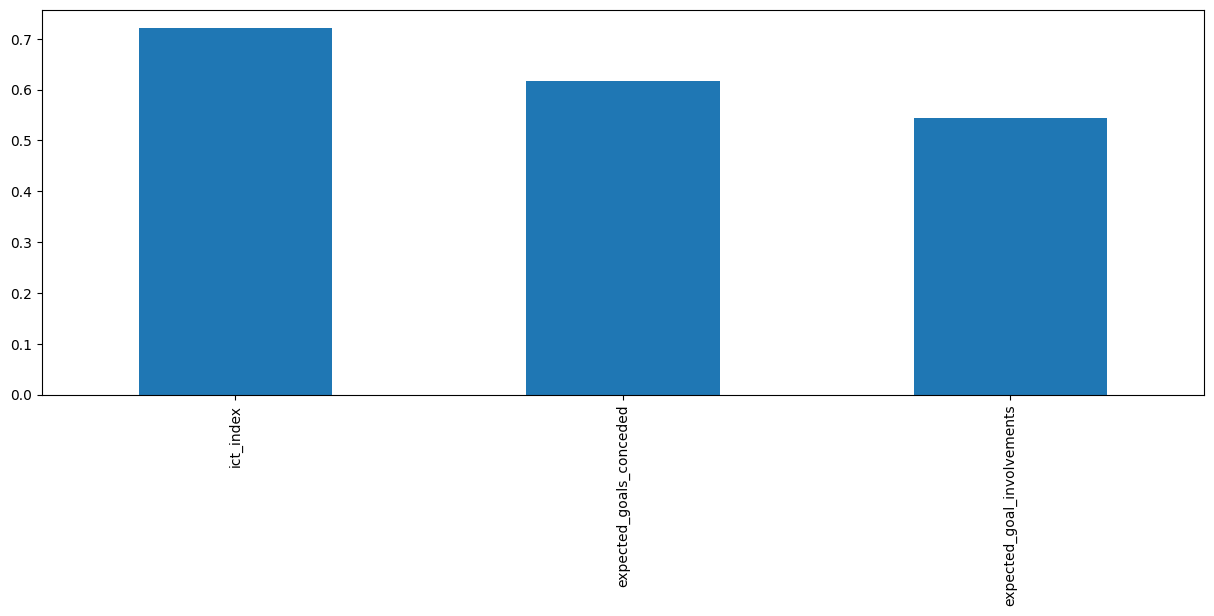

In [89]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))

##### Select to 20% perct

In [90]:
from sklearn.feature_selection import SelectPercentile

## Selecting the top 20 percentile
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=50)
selected_top_columns.fit(k_sel_X_train, mid_splits['target_train'])

selected_top_columns.get_support()

array([ True, False, False])

In [91]:
mid_20_columns = k_sel_X_train.columns[selected_top_columns.get_support()]

mid_20_train = k_sel_X_train[mid_20_columns]
mid_20_test = k_sel_X_test[mid_20_columns]


##### Model (MI)

###### Linear Model

In [92]:

MI_mid_lin_reg = Linear_regression(mid_20_train, mid_20_test,
                               mid_splits['target_train'], mid_splits['target_test'])

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(MI_mid_lin_reg =  [MI_mid_lin_reg['train_RMSE'], MI_mid_lin_reg['test_RMSE'], MI_mid_lin_reg['cv_rmse'], MI_mid_lin_reg['R2_train'], MI_mid_lin_reg['R2_test']])

mid_evaluation_stats

Training set RMSE: 1.2577825615187501
Test set RMSE: 1.2154149743290905
Training set R2: 0.7314406194151063
Test set R2: 0.7255944186445654
count    10.000000
mean      1.255695
std       0.090364
min       1.156228
25%       1.177082
50%       1.242016
75%       1.327572
max       1.409616
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg,KBest_mid_dt_reg,KBest_mid_rf_reg,KBest_mid_xgb_reg,MI_mid_lin_reg
train_RMSE,1.214109,0.042880,0.846176,1.037749,1.214109,0.042880,0.844437,1.037749,1.257578,0.093048,0.980473,1.133578,1.257783
test_RMSE,1.182739,1.672228,1.109898,1.103781,1.182739,1.668665,1.104714,1.103781,1.214366,1.599654,1.194602,1.190979,1.215415
cv_rmse,1.220826,1.617324,1.181929,1.176367,1.220826,1.633782,1.181397,1.176367,1.257376,1.712605,1.246580,1.232367,1.255695
R2_train,0.749767,0.999688,0.878451,0.817184,0.749767,0.999688,0.878950,0.817184,0.731528,0.998530,0.836808,0.781862,0.731441
R2_test,0.740151,0.480561,0.771171,0.773687,0.740151,0.482772,0.773304,0.773687,0.726068,0.524669,0.734912,0.736517,0.725594


###### DecisionTree Model

In [93]:
MI_mid_dt_reg = DecisionTreeRegression(mid_20_train, mid_20_test,
                               mid_splits['target_train'], mid_splits['target_test'])

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(MI_mid_dt_reg = [MI_mid_dt_reg['train_RMSE'], MI_mid_dt_reg['test_RMSE'], MI_mid_dt_reg['cv_rmse'], MI_mid_dt_reg['R2_train'], MI_mid_dt_reg['R2_test']])

mid_evaluation_stats



Training set RMSE: 1.102428078879776
Test set RMSE: 1.2815373809864679
Training set R2: 0.7936855147740101
Test set R2: 0.6949252020248802
count    10.000000
mean      1.345599
std       0.055373
min       1.263891
25%       1.301244
50%       1.338207
75%       1.389124
max       1.435115
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg,KBest_mid_dt_reg,KBest_mid_rf_reg,KBest_mid_xgb_reg,MI_mid_lin_reg,MI_mid_dt_reg
train_RMSE,1.214109,0.042880,0.846176,1.037749,1.214109,0.042880,0.844437,1.037749,1.257578,0.093048,0.980473,1.133578,1.257783,1.102428
test_RMSE,1.182739,1.672228,1.109898,1.103781,1.182739,1.668665,1.104714,1.103781,1.214366,1.599654,1.194602,1.190979,1.215415,1.281537
cv_rmse,1.220826,1.617324,1.181929,1.176367,1.220826,1.633782,1.181397,1.176367,1.257376,1.712605,1.246580,1.232367,1.255695,1.345599
R2_train,0.749767,0.999688,0.878451,0.817184,0.749767,0.999688,0.878950,0.817184,0.731528,0.998530,0.836808,0.781862,0.731441,0.793686
R2_test,0.740151,0.480561,0.771171,0.773687,0.740151,0.482772,0.773304,0.773687,0.726068,0.524669,0.734912,0.736517,0.725594,0.694925


###### RandomForest Model

In [94]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
MI_mid_rf_reg = RandomForestRegression(mid_20_train, mid_20_test,
                               mid_splits['target_train'], mid_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(MI_mid_rf_reg = [MI_mid_rf_reg['train_RMSE'], MI_mid_rf_reg['test_RMSE'], MI_mid_rf_reg['cv_rmse'], MI_mid_rf_reg['R2_train'], MI_mid_rf_reg['R2_test']])

mid_evaluation_stats

count    10.000000
mean      1.274039
std       0.068912
min       1.201338
25%       1.219020
50%       1.255425
75%       1.304194
max       1.404505
dtype: float64


,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg,KBest_mid_dt_reg,KBest_mid_rf_reg,KBest_mid_xgb_reg,MI_mid_lin_reg,MI_mid_dt_reg,MI_mid_rf_reg
train_RMSE,1.214109,0.042880,0.846176,1.037749,1.214109,0.042880,0.844437,1.037749,1.257578,0.093048,0.980473,1.133578,1.257783,1.102428,1.128031
test_RMSE,1.182739,1.672228,1.109898,1.103781,1.182739,1.668665,1.104714,1.103781,1.214366,1.599654,1.194602,1.190979,1.215415,1.281537,1.231860
cv_rmse,1.220826,1.617324,1.181929,1.176367,1.220826,1.633782,1.181397,1.176367,1.257376,1.712605,1.246580,1.232367,1.255695,1.345599,1.274039
R2_train,0.749767,0.999688,0.878451,0.817184,0.749767,0.999688,0.878950,0.817184,0.731528,0.998530,0.836808,0.781862,0.731441,0.793686,0.783991
R2_test,0.740151,0.480561,0.771171,0.773687,0.740151,0.482772,0.773304,0.773687,0.726068,0.524669,0.734912,0.736517,0.725594,0.694925,0.718118


###### XgBoost Model

In [95]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
MI_mid_xgb_reg = XGBoostRegression(k_sel_X_train, k_sel_X_test, mid_splits['target_train'], mid_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
mid_evaluation_stats = mid_evaluation_stats.assign(MI_mid_xgb_reg = [MI_mid_xgb_reg['train_RMSE'], MI_mid_xgb_reg['test_RMSE'], MI_mid_xgb_reg['cv_rmse'], MI_mid_xgb_reg['R2_train'], MI_mid_xgb_reg['R2_test']])
mid_evaluation_stats

,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg,KBest_mid_dt_reg,KBest_mid_rf_reg,KBest_mid_xgb_reg,MI_mid_lin_reg,MI_mid_dt_reg,MI_mid_rf_reg,MI_mid_xgb_reg
train_RMSE,1.214109,0.042880,0.846176,1.037749,1.214109,0.042880,0.844437,1.037749,1.257578,0.093048,0.980473,1.133578,1.257783,1.102428,1.128031,1.133578
test_RMSE,1.182739,1.672228,1.109898,1.103781,1.182739,1.668665,1.104714,1.103781,1.214366,1.599654,1.194602,1.190979,1.215415,1.281537,1.231860,1.190979
cv_rmse,1.220826,1.617324,1.181929,1.176367,1.220826,1.633782,1.181397,1.176367,1.257376,1.712605,1.246580,1.232367,1.255695,1.345599,1.274039,1.232367
R2_train,0.749767,0.999688,0.878451,0.817184,0.749767,0.999688,0.878950,0.817184,0.731528,0.998530,0.836808,0.781862,0.731441,0.793686,0.783991,0.781862
R2_test,0.740151,0.480561,0.771171,0.773687,0.740151,0.482772,0.773304,0.773687,0.726068,0.524669,0.734912,0.736517,0.725594,0.694925,0.718118,0.736517


## Forwards


### VarianceThreshold

In [96]:
VT_scaler = StandardScaler()
df_for_train_scaled = pd.DataFrame(VT_scaler.fit_transform(for_splits['feature_train']), columns=for_splits['feature_train'].columns)
df_for_test_scaled = pd.DataFrame(VT_scaler.transform(for_splits['features_test']), columns=for_splits['features_test'].columns)

selector = VarianceThreshold(threshold = 0.1)
selector.fit_transform(df_for_train_scaled)

for_threshold_columns = df_for_train_scaled.columns[selector.get_support()]

for_threshold_train = df_for_train_scaled[for_threshold_columns]
for_threshold_test = df_for_test_scaled[for_threshold_columns]

for_threshold_train.shape, for_threshold_test.shape

((2717, 21), (680, 21))

#### Model(VT)

##### Linear Model

In [97]:

VarT_for_lin_reg = Linear_regression(for_threshold_train, for_threshold_test,
                               for_splits['target_train'], for_splits['target_test'])

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(VarT_for_lin_reg =  [VarT_for_lin_reg['train_RMSE'], VarT_for_lin_reg['test_RMSE'], VarT_for_lin_reg['cv_rmse'], VarT_for_lin_reg['R2_train'], VarT_for_lin_reg['R2_test']])

for_evaluation_stats

Training set RMSE: 1.1284623902708093
Test set RMSE: 1.1896871018147992
Training set R2: 0.805237909773716
Test set R2: 0.7975301396542591
count    10.000000
mean      1.148992
std       0.131439
min       0.971006
25%       1.091428
50%       1.132952
75%       1.187223
max       1.380769
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg
train_RMSE,1.128462,0.038295,0.665386,0.864984,1.128462
test_RMSE,1.189687,1.592263,1.196571,1.198282,1.189687
cv_rmse,1.148992,1.575173,1.130758,1.125754,1.148992
R2_train,0.805238,0.999776,0.932286,0.885568,0.805238
R2_test,0.797530,0.637319,0.795180,0.794594,0.797530


##### DecisionTree Model

In [98]:
VarT_for_dt_reg = DecisionTreeRegression(for_threshold_train, for_threshold_test,
                               for_splits['target_train'], for_splits['target_test'])

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(VarT_for_dt_reg = [VarT_for_dt_reg['train_RMSE'], VarT_for_dt_reg['test_RMSE'], VarT_for_dt_reg['cv_rmse'], VarT_for_dt_reg['R2_train'], VarT_for_dt_reg['R2_test']])

for_evaluation_stats



Training set RMSE: 0.03829456355736556
Test set RMSE: 1.6903724221104475
Training set R2: 0.9997757127962017
Test set R2: 0.591248203456166
count    10.000000
mean      1.586450
std       0.175943
min       1.335326
25%       1.461724
50%       1.521976
75%       1.746932
max       1.858013
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg
train_RMSE,1.128462,0.038295,0.665386,0.864984,1.128462,0.038295
test_RMSE,1.189687,1.592263,1.196571,1.198282,1.189687,1.690372
cv_rmse,1.148992,1.575173,1.130758,1.125754,1.148992,1.586450
R2_train,0.805238,0.999776,0.932286,0.885568,0.805238,0.999776
R2_test,0.797530,0.637319,0.795180,0.794594,0.797530,0.591248


##### RandomForest Model

In [99]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
VarT_for_rf_reg = RandomForestRegression(for_threshold_train, for_threshold_test,
                               for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(VarT_for_rf_reg = [VarT_for_rf_reg['train_RMSE'], VarT_for_rf_reg['test_RMSE'], VarT_for_rf_reg['cv_rmse'], VarT_for_rf_reg['R2_train'], VarT_for_rf_reg['R2_test']])

for_evaluation_stats

count    10.000000
mean      1.136361
std       0.135195
min       0.893734
25%       1.081144
50%       1.136099
75%       1.247615
max       1.314056
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg
train_RMSE,1.128462,0.038295,0.665386,0.864984,1.128462,0.038295,0.664370
test_RMSE,1.189687,1.592263,1.196571,1.198282,1.189687,1.690372,1.194025
cv_rmse,1.148992,1.575173,1.130758,1.125754,1.148992,1.586450,1.136361
R2_train,0.805238,0.999776,0.932286,0.885568,0.805238,0.999776,0.932493
R2_test,0.797530,0.637319,0.795180,0.794594,0.797530,0.591248,0.796051


##### XgBoost Model

In [100]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
VarT_for_xgb_reg = XGBoostRegression(for_threshold_train, for_threshold_test, for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(VarT_for_xgb_reg = [VarT_for_xgb_reg['train_RMSE'], VarT_for_xgb_reg['test_RMSE'], VarT_for_xgb_reg['cv_rmse'], VarT_for_xgb_reg['R2_train'], VarT_for_xgb_reg['R2_test']])
for_evaluation_stats

,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg
train_RMSE,1.128462,0.038295,0.665386,0.864984,1.128462,0.038295,0.664370,0.864984
test_RMSE,1.189687,1.592263,1.196571,1.198282,1.189687,1.690372,1.194025,1.198282
cv_rmse,1.148992,1.575173,1.130758,1.125754,1.148992,1.586450,1.136361,1.125754
R2_train,0.805238,0.999776,0.932286,0.885568,0.805238,0.999776,0.932493,0.885568
R2_test,0.797530,0.637319,0.795180,0.794594,0.797530,0.591248,0.796051,0.794594


### Feature selection techniques

#### K-best features

In [101]:

from sklearn.feature_selection import SelectKBest, mutual_info_regression

k_rf_model = RandomForestRegressor(n_estimators=20,  max_depth=8, criterion='friedman_mse', max_features='sqrt', random_state=18)

score_list  = []

for k in range(1, 21):
  selector = SelectKBest(mutual_info_regression, k=k)
  k_sel_X_train =  selector.fit_transform(for_threshold_train, for_splits['target_train'])

  k_rf_model.fit(k_sel_X_train, for_splits['target_train'])

  k_sel_cols = for_threshold_train.columns[selector.get_support()]
  k_sel_X_test = for_threshold_test[k_sel_cols]
  score = round(k_rf_model.score(k_sel_X_test.values, for_splits['target_test'] ), 3)

  score_list.append(score)
print(score_list, score_list.index(max(score_list)))
num_of_feat = score_list.index(max(score_list)) # find the highest score. We will use  that as the value of k

[0.782, 0.787, 0.783, 0.787, 0.791, 0.787, 0.783, 0.752, 0.778, 0.758, 0.748, 0.765, 0.725, 0.751, 0.739, 0.735, 0.753, 0.749, 0.717, 0.737] 4


In [102]:
selector = SelectKBest(mutual_info_regression, k=num_of_feat)
selector.fit_transform(for_threshold_train, for_splits['target_train'])

sel_feats = selector.get_feature_names_out()
k_sel_X_train = for_threshold_train[sel_feats]
k_sel_X_test = for_threshold_test[sel_feats]

##### Model (KBest)

###### Linear Model

In [103]:

KBest_for_lin_reg = Linear_regression(k_sel_X_train, k_sel_X_test,
                               for_splits['target_train'], for_splits['target_test'])

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(KBest_for_lin_reg =  [KBest_for_lin_reg['train_RMSE'], KBest_for_lin_reg['test_RMSE'], KBest_for_lin_reg['cv_rmse'], KBest_for_lin_reg['R2_train'], KBest_for_lin_reg['R2_test']])

for_evaluation_stats

Training set RMSE: 1.1385991626853407
Test set RMSE: 1.180982403814736
Training set R2: 0.8017231693527817
Test set R2: 0.8004821617150986
count    10.000000
mean      1.139444
std       0.129776
min       0.952797
25%       1.099756
50%       1.137224
75%       1.172026
max       1.360895
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg
train_RMSE,1.128462,0.038295,0.665386,0.864984,1.128462,0.038295,0.664370,0.864984,1.138599
test_RMSE,1.189687,1.592263,1.196571,1.198282,1.189687,1.690372,1.194025,1.198282,1.180982
cv_rmse,1.148992,1.575173,1.130758,1.125754,1.148992,1.586450,1.136361,1.125754,1.139444
R2_train,0.805238,0.999776,0.932286,0.885568,0.805238,0.999776,0.932493,0.885568,0.801723
R2_test,0.797530,0.637319,0.795180,0.794594,0.797530,0.591248,0.796051,0.794594,0.800482


###### DecisionTree Model

In [104]:
KBest_for_dt_reg = DecisionTreeRegression(k_sel_X_train, k_sel_X_test,
                               for_splits['target_train'], for_splits['target_test'])

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(KBest_for_dt_reg = [KBest_for_dt_reg['train_RMSE'], KBest_for_dt_reg['test_RMSE'], KBest_for_dt_reg['cv_rmse'], KBest_for_dt_reg['R2_train'], KBest_for_dt_reg['R2_test']])

for_evaluation_stats



Training set RMSE: 0.08904277834353495
Test set RMSE: 1.560840279058158
Training set R2: 0.9987873718291729
Test set R2: 0.6514927598329552
count    10.000000
mean      1.561022
std       0.124088
min       1.355030
25%       1.473510
50%       1.565629
75%       1.625634
max       1.751267
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg
train_RMSE,1.128462,0.038295,0.665386,0.864984,1.128462,0.038295,0.664370,0.864984,1.138599,0.089043
test_RMSE,1.189687,1.592263,1.196571,1.198282,1.189687,1.690372,1.194025,1.198282,1.180982,1.560840
cv_rmse,1.148992,1.575173,1.130758,1.125754,1.148992,1.586450,1.136361,1.125754,1.139444,1.561022
R2_train,0.805238,0.999776,0.932286,0.885568,0.805238,0.999776,0.932493,0.885568,0.801723,0.998787
R2_test,0.797530,0.637319,0.795180,0.794594,0.797530,0.591248,0.796051,0.794594,0.800482,0.651493


###### RandomForest Model

In [105]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
KBest_for_rf_reg = RandomForestRegression(k_sel_X_train, k_sel_X_test,
                               for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(KBest_for_rf_reg = [KBest_for_rf_reg['train_RMSE'], KBest_for_rf_reg['test_RMSE'], KBest_for_rf_reg['cv_rmse'], KBest_for_rf_reg['R2_train'], KBest_for_rf_reg['R2_test']])

for_evaluation_stats

count    10.000000
mean      1.152200
std       0.112522
min       0.953720
25%       1.075216
50%       1.142285
75%       1.245351
max       1.307463
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg,KBest_for_rf_reg
train_RMSE,1.128462,0.038295,0.665386,0.864984,1.128462,0.038295,0.664370,0.864984,1.138599,0.089043,0.726646
test_RMSE,1.189687,1.592263,1.196571,1.198282,1.189687,1.690372,1.194025,1.198282,1.180982,1.560840,1.143773
cv_rmse,1.148992,1.575173,1.130758,1.125754,1.148992,1.586450,1.136361,1.125754,1.139444,1.561022,1.152200
R2_train,0.805238,0.999776,0.932286,0.885568,0.805238,0.999776,0.932493,0.885568,0.801723,0.998787,0.919244
R2_test,0.797530,0.637319,0.795180,0.794594,0.797530,0.591248,0.796051,0.794594,0.800482,0.651493,0.812856


###### XgBoost Model

In [106]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
KBest_for_xgb_reg = XGBoostRegression(k_sel_X_train, k_sel_X_test, for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(KBest_for_xgb_reg = [KBest_for_xgb_reg['train_RMSE'], KBest_for_xgb_reg['test_RMSE'], KBest_for_xgb_reg['cv_rmse'], KBest_for_xgb_reg['R2_train'], KBest_for_xgb_reg['R2_test']])
for_evaluation_stats

,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg,KBest_for_rf_reg,KBest_for_xgb_reg
train_RMSE,1.128462,0.038295,0.665386,0.864984,1.128462,0.038295,0.664370,0.864984,1.138599,0.089043,0.726646,0.927749
test_RMSE,1.189687,1.592263,1.196571,1.198282,1.189687,1.690372,1.194025,1.198282,1.180982,1.560840,1.143773,1.199956
cv_rmse,1.148992,1.575173,1.130758,1.125754,1.148992,1.586450,1.136361,1.125754,1.139444,1.561022,1.152200,1.142675
R2_train,0.805238,0.999776,0.932286,0.885568,0.805238,0.999776,0.932493,0.885568,0.801723,0.998787,0.919244,0.868359
R2_test,0.797530,0.637319,0.795180,0.794594,0.797530,0.591248,0.796051,0.794594,0.800482,0.651493,0.812856,0.794020


#### Mutual Information

In [107]:
from sklearn.feature_selection import mutual_info_regression
# def_sel_X_train
mutual_info = mutual_info_regression(k_sel_X_train, for_splits['target_train'])
mutual_info

array([0.70528202, 0.43820242, 0.53558289, 0.54770953])

In [108]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = k_sel_X_train.columns
mutual_info.sort_values(ascending=False)

,0
ict_index,0.705282
expected_goals_conceded,0.547710
expected_goal_involvements,0.535583
expected_goals,0.438202


<Axes: >

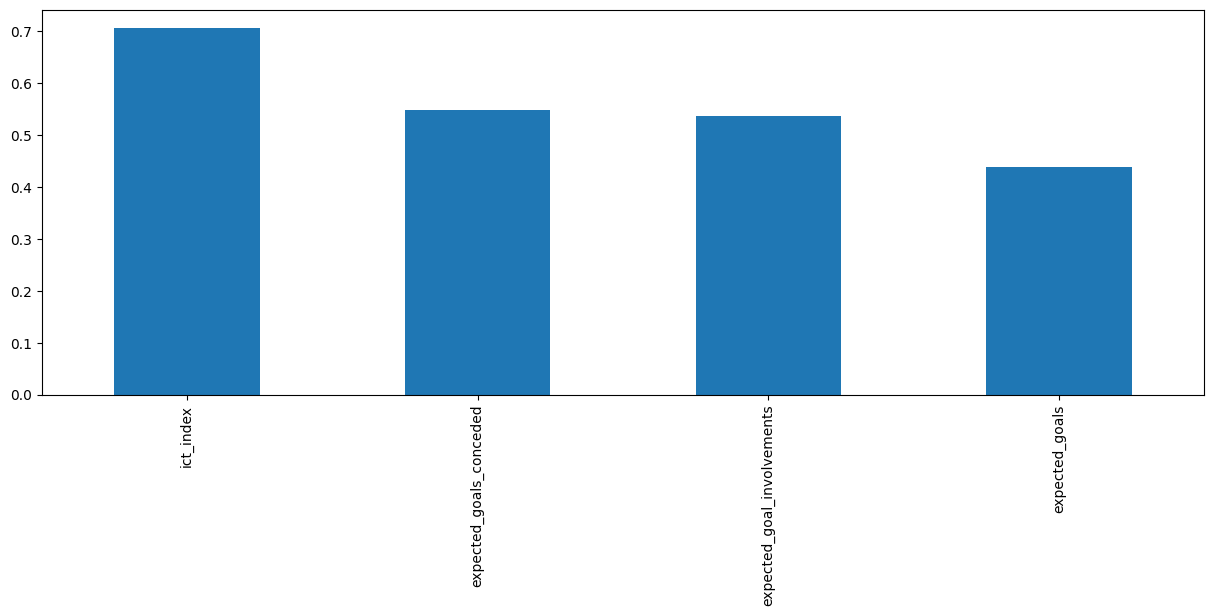

In [109]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))

##### Select to 20% perct

In [110]:
from sklearn.feature_selection import SelectPercentile

## Selecting the top 20 percentile
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=50)
selected_top_columns.fit(k_sel_X_train, for_splits['target_train'])

selected_top_columns.get_support()

array([ True, False,  True, False])

In [111]:
for_20_columns = k_sel_X_train.columns[selected_top_columns.get_support()]

for_20_train = k_sel_X_train[for_20_columns]
for_20_test = k_sel_X_test[for_20_columns]


##### Model (MI)

###### Linear Model

In [112]:

MI_for_lin_reg = Linear_regression(for_20_train, for_20_test,
                               for_splits['target_train'], for_splits['target_test'])

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(MI_for_lin_reg =  [MI_for_lin_reg['train_RMSE'], MI_for_lin_reg['test_RMSE'], MI_for_lin_reg['cv_rmse'], MI_for_lin_reg['R2_train'], MI_for_lin_reg['R2_test']])

for_evaluation_stats

Training set RMSE: 1.150957057437861
Test set RMSE: 1.1986522359469252
Training set R2: 0.7973957792008227
Test set R2: 0.7944671346909166
count    10.000000
mean      1.147929
std       0.134028
min       0.952753
25%       1.089634
50%       1.143934
75%       1.200425
max       1.381949
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg,KBest_for_rf_reg,KBest_for_xgb_reg,MI_for_lin_reg
train_RMSE,1.128462,0.038295,0.665386,0.864984,1.128462,0.038295,0.664370,0.864984,1.138599,0.089043,0.726646,0.927749,1.150957
test_RMSE,1.189687,1.592263,1.196571,1.198282,1.189687,1.690372,1.194025,1.198282,1.180982,1.560840,1.143773,1.199956,1.198652
cv_rmse,1.148992,1.575173,1.130758,1.125754,1.148992,1.586450,1.136361,1.125754,1.139444,1.561022,1.152200,1.142675,1.147929
R2_train,0.805238,0.999776,0.932286,0.885568,0.805238,0.999776,0.932493,0.885568,0.801723,0.998787,0.919244,0.868359,0.797396
R2_test,0.797530,0.637319,0.795180,0.794594,0.797530,0.591248,0.796051,0.794594,0.800482,0.651493,0.812856,0.794020,0.794467


###### DecisionTree Model

In [113]:
MI_for_dt_reg = DecisionTreeRegression(for_20_train, for_20_test,
                               for_splits['target_train'], for_splits['target_test'])

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(MI_for_dt_reg = [MI_for_dt_reg['train_RMSE'], MI_for_dt_reg['test_RMSE'], MI_for_dt_reg['cv_rmse'], MI_for_dt_reg['R2_train'], MI_for_dt_reg['R2_test']])

for_evaluation_stats



Training set RMSE: 0.2990649635391607
Test set RMSE: 1.5509075643084225
Training set R2: 0.9863207803854398
Test set R2: 0.6559142354841974
count    10.000000
mean      1.521030
std       0.138838
min       1.315508
25%       1.397524
50%       1.580346
75%       1.625853
max       1.639824
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg,KBest_for_rf_reg,KBest_for_xgb_reg,MI_for_lin_reg,MI_for_dt_reg
train_RMSE,1.128462,0.038295,0.665386,0.864984,1.128462,0.038295,0.664370,0.864984,1.138599,0.089043,0.726646,0.927749,1.150957,0.299065
test_RMSE,1.189687,1.592263,1.196571,1.198282,1.189687,1.690372,1.194025,1.198282,1.180982,1.560840,1.143773,1.199956,1.198652,1.550908
cv_rmse,1.148992,1.575173,1.130758,1.125754,1.148992,1.586450,1.136361,1.125754,1.139444,1.561022,1.152200,1.142675,1.147929,1.521030
R2_train,0.805238,0.999776,0.932286,0.885568,0.805238,0.999776,0.932493,0.885568,0.801723,0.998787,0.919244,0.868359,0.797396,0.986321
R2_test,0.797530,0.637319,0.795180,0.794594,0.797530,0.591248,0.796051,0.794594,0.800482,0.651493,0.812856,0.794020,0.794467,0.655914


###### RandomForest Model

In [114]:
hyperparameters = {"criterion": 'friedman_mse', "max_depth": 8, "max_features": 'sqrt', "n_estimators": 20}
MI_for_rf_reg = RandomForestRegression(for_20_train, for_20_test,
                               for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(MI_for_rf_reg = [MI_for_rf_reg['train_RMSE'], MI_for_rf_reg['test_RMSE'], MI_for_rf_reg['cv_rmse'], MI_for_rf_reg['R2_train'], MI_for_rf_reg['R2_test']])

for_evaluation_stats

count    10.000000
mean      1.171645
std       0.119634
min       0.939598
25%       1.103691
50%       1.164353
75%       1.276455
max       1.327259
dtype: float64


,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg,KBest_for_rf_reg,KBest_for_xgb_reg,MI_for_lin_reg,MI_for_dt_reg,MI_for_rf_reg
train_RMSE,1.128462,0.038295,0.665386,0.864984,1.128462,0.038295,0.664370,0.864984,1.138599,0.089043,0.726646,0.927749,1.150957,0.299065,0.796079
test_RMSE,1.189687,1.592263,1.196571,1.198282,1.189687,1.690372,1.194025,1.198282,1.180982,1.560840,1.143773,1.199956,1.198652,1.550908,1.228322
cv_rmse,1.148992,1.575173,1.130758,1.125754,1.148992,1.586450,1.136361,1.125754,1.139444,1.561022,1.152200,1.142675,1.147929,1.521030,1.171645
R2_train,0.805238,0.999776,0.932286,0.885568,0.805238,0.999776,0.932493,0.885568,0.801723,0.998787,0.919244,0.868359,0.797396,0.986321,0.903073
R2_test,0.797530,0.637319,0.795180,0.794594,0.797530,0.591248,0.796051,0.794594,0.800482,0.651493,0.812856,0.794020,0.794467,0.655914,0.784166


###### XgBoost Model

In [115]:
hyperparameters = {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
MI_for_xgb_reg = XGBoostRegression(k_sel_X_train, k_sel_X_test, for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
for_evaluation_stats = for_evaluation_stats.assign(MI_for_xgb_reg = [MI_for_xgb_reg['train_RMSE'], MI_for_xgb_reg['test_RMSE'], MI_for_xgb_reg['cv_rmse'], MI_for_xgb_reg['R2_train'], MI_for_xgb_reg['R2_test']])
for_evaluation_stats

,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg,KBest_for_rf_reg,KBest_for_xgb_reg,MI_for_lin_reg,MI_for_dt_reg,MI_for_rf_reg,MI_for_xgb_reg
train_RMSE,1.128462,0.038295,0.665386,0.864984,1.128462,0.038295,0.664370,0.864984,1.138599,0.089043,0.726646,0.927749,1.150957,0.299065,0.796079,0.927749
test_RMSE,1.189687,1.592263,1.196571,1.198282,1.189687,1.690372,1.194025,1.198282,1.180982,1.560840,1.143773,1.199956,1.198652,1.550908,1.228322,1.199956
cv_rmse,1.148992,1.575173,1.130758,1.125754,1.148992,1.586450,1.136361,1.125754,1.139444,1.561022,1.152200,1.142675,1.147929,1.521030,1.171645,1.142675
R2_train,0.805238,0.999776,0.932286,0.885568,0.805238,0.999776,0.932493,0.885568,0.801723,0.998787,0.919244,0.868359,0.797396,0.986321,0.903073,0.868359
R2_test,0.797530,0.637319,0.795180,0.794594,0.797530,0.591248,0.796051,0.794594,0.800482,0.651493,0.812856,0.794020,0.794467,0.655914,0.784166,0.794020


# Best Stats

In [148]:
gk_evaluation_stats

,base_gk_lin_reg,base_gk_dt_reg,base_gk_rf_reg,base_gk_xgb_reg,VarT_gk_lin_reg,VarT_gk_dt_reg,VarT_gk_rf_reg,VarT_gk_xgb_reg,KBest_gk_lin_reg,KBest_gk_dt_reg,KBest_gk_rf_reg,KBest_gk_xgb_reg,MI_gk_lin_reg,MI_gk_dt_reg,MI_gk_rf_reg,MI_gk_xgb_reg
train_RMSE,1.161926,0.035196,0.757658,0.892989,1.166336,0.035196,0.759153,0.892989,1.232308,0.117008,0.836169,0.961547,1.268165,1.085436,1.097823,0.961547
test_RMSE,1.235357,1.495157,1.152307,1.175463,1.241539,1.410694,1.154696,1.175463,1.286200,1.432425,1.136594,1.123488,1.301284,1.311391,1.313343,1.123488
cv_rmse,1.188035,1.507652,1.129481,1.107850,1.191555,1.509706,1.134954,1.107850,1.233383,1.501838,1.151050,1.121890,1.265201,1.255214,1.215899,1.121890
R2_train,0.623218,0.999654,0.839794,0.777451,0.620353,0.999654,0.839161,0.777451,0.576190,0.996179,0.804871,0.741968,0.551168,0.671193,0.663645,0.741968
R2_test,0.544742,0.333122,0.603897,0.587817,0.540174,0.406340,0.602252,0.587817,0.506497,0.387909,0.614626,0.623462,0.494855,0.486977,0.485449,0.623462


In [149]:
# Goalkeepers
#### XgBoost Model under the Variance threshold performed better


In [150]:
def_evaluation_stats

,base_def_lin_reg,base_def_dt_reg,base_def_rf_reg,base_def_xgb_reg,VarT_def_lin_reg,VarT_def_dt_reg,VarT_def_rf_reg,VarT_def_xgb_reg,KBest_def_lin_reg,KBest_def_dt_reg,KBest_def_rf_reg,KBest_def_xgb_reg,MI_def_lin_reg,MI_def_dt_reg,MI_def_rf_reg,MI_def_xgb_reg
train_RMSE,1.528129,0.031296,1.144598,1.338167,1.528129,0.031296,1.144095,1.338167,1.537976,0.052255,1.187744,1.354777,1.561224,0.332285,1.266506,1.354777
test_RMSE,1.547962,2.110464,1.520657,1.504497,1.547962,2.060051,1.524286,1.504497,1.550029,2.108376,1.496682,1.494898,1.561262,2.041492,1.546156,1.494898
cv_rmse,1.536999,2.115961,1.486946,1.476898,1.536999,2.126267,1.487599,1.476898,1.538774,2.070915,1.484410,1.472449,1.559501,2.041158,1.506043,1.472449
R2_train,0.525298,0.999801,0.733678,0.635983,0.525298,0.999801,0.733912,0.635983,0.519161,0.999445,0.713221,0.626890,0.504514,0.977555,0.673927,0.626890
R2_test,0.521779,0.111076,0.538500,0.548257,0.521779,0.153037,0.536295,0.548257,0.520500,0.112835,0.552938,0.554003,0.513525,0.168228,0.522894,0.554003


In [151]:
# Defenders
#### Rf Model under the Variance threshold performed better

In [152]:
mid_evaluation_stats

,base_mid_lin_reg,base_mid_dt_reg,base_mid_rf_reg,base_mid_xgb_reg,VarT_mid_lin_reg,VarT_mid_dt_reg,VarT_mid_rf_reg,VarT_mid_xgb_reg,KBest_mid_lin_reg,KBest_mid_dt_reg,KBest_mid_rf_reg,KBest_mid_xgb_reg,MI_mid_lin_reg,MI_mid_dt_reg,MI_mid_rf_reg,MI_mid_xgb_reg
train_RMSE,1.205072,0.044234,0.834991,1.021547,1.205072,0.044234,0.834061,1.021547,1.213122,0.065749,0.868323,1.046002,1.250478,0.226383,1.009431,1.046002
test_RMSE,1.224586,1.614120,1.183569,1.201454,1.224586,1.623789,1.186505,1.201454,1.218829,1.684806,1.208846,1.214833,1.244995,1.652737,1.261288,1.214833
cv_rmse,1.212407,1.599599,1.155467,1.153411,1.212407,1.610269,1.155957,1.153411,1.213660,1.624869,1.163703,1.156576,1.248435,1.685087,1.261543,1.156576
R2_train,0.746038,0.999658,0.878071,0.817502,0.746038,0.999658,0.878343,0.817502,0.742634,0.999244,0.868143,0.808659,0.726540,0.991037,0.821805,0.808659
R2_test,0.753078,0.571003,0.769342,0.762318,0.753078,0.565849,0.768196,0.762318,0.755394,0.532607,0.759384,0.756995,0.744779,0.550231,0.738055,0.756995


In [153]:
# Midfielders
#### RF Model under the Variance threshold performed better

In [154]:
for_evaluation_stats

,base_for_lin_reg,base_for_dt_reg,base_for_rf_reg,base_for_xgb_reg,VarT_for_lin_reg,VarT_for_dt_reg,VarT_for_rf_reg,VarT_for_xgb_reg,KBest_for_lin_reg,KBest_for_dt_reg,KBest_for_rf_reg,KBest_for_xgb_reg,MI_for_lin_reg,MI_for_dt_reg,MI_for_rf_reg,MI_for_xgb_reg
train_RMSE,1.116065,0.036669,0.645369,0.860099,1.116065,0.036669,0.646468,0.860099,1.119536,0.036691,0.652194,0.859895,1.121488,0.045418,0.650720,0.859895
test_RMSE,1.230522,1.580673,1.219686,1.249217,1.230522,1.615640,1.219900,1.249217,1.228707,1.678146,1.206758,1.247320,1.234979,1.566358,1.277393,1.247320
cv_rmse,1.149759,1.569550,1.147506,1.157798,1.149759,1.524163,1.139910,1.157798,1.145902,1.534893,1.141721,1.151140,1.137865,1.425981,1.130219,1.151140
R2_train,0.811998,0.999797,0.937136,0.888344,0.811998,0.999797,0.936922,0.888344,0.810826,0.999797,0.935800,0.888397,0.810166,0.999689,0.936090,0.888397
R2_test,0.772085,0.623921,0.776081,0.765107,0.772085,0.607099,0.776003,0.765107,0.772757,0.576109,0.780803,0.765820,0.770431,0.630702,0.754391,0.765820


In [155]:
# Forwards
#### RF Model under the KBest performed better


## Fine tuning the models

### XgBoost (Goalkeepers and Forwards)

In [116]:

from sklearn.model_selection import GridSearchCV
import numpy as np

# =========================================================================
# XGBoost regression:
# Parameters:
# n_estimators  "Number of gradient boosted trees. Equivalent to number
#                of boosting rounds."
# learning_rate "Boosting learning rate (also known as “eta”)"
# max_depth     "Maximum depth of a tree. Increasing this value will make
#                the model more complex and more likely to overfit."
# =========================================================================
regressor = xgb(eval_metric='rmsle')

# =========================================================================
# exhaustively search for the optimal hyperparameters
# =========================================================================
# set up our search grid
param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": np.arange(100, 1000, 50),
              "learning_rate": np.arange(0.01, .2, 0.005)}


In [157]:
# try out every combination of the above values
goalkeepers_search = GridSearchCV(regressor, param_grid, cv=5).fit(
    gk_threshold_train, gk_splits['target_train'])

print("The best hyperparameters are ", goalkeepers_search.best_params_)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-157-e6d530c6dfbc>", line 2, in <cell line: 2>
    goalkeepers_search = GridSearchCV(regressor, param_grid, cv=5).fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py", line 898, in fit
    self._run_search(evaluate_candidates)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py", line 1422, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py", line 845, in evaluate_candidates
    out = parallel(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py", l

TypeError: object of type 'NoneType' has no len()

In [117]:
model = RandomForestRegressor()

param_grid = {'n_estimators': [8, 10, 12, 14, 16, 18, 20]}

# Define the possible values of the hyperparameter
grid = {
    'n_estimators': [8, 10, 12, 14, 16, 18, 20, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [4, 5, 6, 7, 8],
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'random_state': [18]
}

In [ ]:
def_grid_search = GridSearchCV(model, grid, cv=5,
                              scoring='neg_root_mean_squared_error')
def_grid_search.fit(def_threshold_train, def_splits['target_train'])

print("The best defender hyperparameters are ", def_grid_search.best_params_)

In [ ]:
# Deine the model with cv=5 for a 5-fold cross validation
# GridSearchCV has the best_estimator_ parameter that returns the  estimator
# which gave highest score (or smallest loss if specified)

mid_grid_search = GridSearchCV(model, grid, cv=5,
                              scoring='neg_root_mean_squared_error')
mid_grid_search.fit(mid_threshold_train, mid_splits['target_train'])


print("The best midfielder hyperparameters are ", mid_grid_search.best_params_)

In [ ]:

forwards_search = GridSearchCV(regressor, param_grid, cv=5).fit(
    k_sel_X_train, for_splits['target_train'])


print("The best midfielder hyperparameters are ", forwards_search.best_params_)

## With the hyperparameters

### Goalkeepers

In [ ]:
hyperparameters = {'learning_rate': 0.024999999999999998, 'max_depth': 4, 'n_estimators': 100} # {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 150}
FT_for_xgb_reg = XGBoostRegression(for_threshold_train, for_threshold_test, for_splits['target_train'], for_splits['target_test'], hyperparameters)

# Store the model evaluation details in a DataFrame
gk_evaluation_stats = for_evaluation_stats.assign(FT_for_xgb_reg = [FT_for_xgb_reg['train_RMSE'], FT_for_xgb_reg['test_RMSE'], FT_for_xgb_reg['cv_rmse'], FT_for_xgb_reg['R2_train'], FT_for_xgb_reg['R2_test']])
gk_evaluation_stats